In [1]:
#!pip install cv2
import os
import sys
import cv2
import time
import pickle
import numpy as np 
import pandas as pd
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, ShuffleSplit
from keras.utils import np_utils
from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
import time
import sklearn
from sklearn import metrics
from sklearn.metrics import classification_report

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
## generators to send image data to the sequential (cnn) model
#classes = ['A', 'C', 'M', 'N', 'S', 'T', 'V']
#classes = ['A', 'N', 'S', 'V']
classes = ['C', 'FA', 'M', 'S']


img_height,img_width = 128,128

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory('100ms/training_set',
                                                    target_size=(img_height,img_width),
                                                    batch_size=20,
                                                    shuffle=False,
                                                    classes=classes,
                                                    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('100ms/testing_set',
                                                  target_size=(img_height,img_width),
                                                  batch_size=20,
                                                  shuffle=False,
                                                  classes=classes,
                                                  class_mode='categorical')

hold_datagen = ImageDataGenerator(rescale=1./255)
hold_generator = hold_datagen.flow_from_directory('100ms/hold_out',
                                                  target_size=(img_height,img_width),
                                                  batch_size=20,
                                                  shuffle=False,
                                                  classes=classes,
                                                  class_mode='categorical')



Found 172796 images belonging to 4 classes.
Found 57600 images belonging to 4 classes.
Found 57600 images belonging to 4 classes.


In [3]:
num_category = 4

## model building
model = Sequential()

## please modify the model as per your requirements
model.add(Conv2D(16, kernel_size=(3, 7), activation='relu',
                 input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D(pool_size=(3, 7)))
model.add(Dropout(rate=0.1))
model.add(Conv2D(32, 3, activation='relu'))
model.add(Conv2D(20, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(rate=0.2))
model.add(Conv2D(120, 3, activation='relu'))
model.add(Flatten())
model.add(Dropout(rate=0.2))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(num_category, activation='softmax'))


In [4]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())
monitor = [ EarlyStopping(monitor='val_loss',
                            min_delta=1e-3,
                            patience=5,
                            verbose=0,
                            mode='auto'),ModelCheckpoint(filepath="spec_100ms_mani_weights.h5",
                                   verbose=0,
                                   save_best_only=True)] # save best model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 122, 16)      1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 17, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 42, 17, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 15, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 38, 13, 20)        5780      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 4, 20)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 4, 20)         0         
__________

### Training model

In [5]:
## no of steps per epoch (total no. of images / batch size of imagedatagenerator)
train_steps = train_generator.n//train_generator.batch_size+1
test_steps = test_generator.n//test_generator.batch_size+1

train_generator.reset()
test_generator.reset()

tic=time.time()
history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps,
                              epochs=25,callbacks= monitor,
                              validation_data=test_generator,
                              validation_steps=test_steps,
                              verbose=1)     
toc=time.time()
print(str(1000*(toc-tic))+"ms")

Epoch 1/25
  17/8640 [..............................] - ETA: 4:52:08 - loss: 1.4399 - acc: 0.1471

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102101). Check your callbacks.
  % delta_t_median)


  18/8640 [..............................] - ETA: 4:42:39 - loss: 1.4335 - acc: 0.1750

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134801). Check your callbacks.
  % delta_t_median)


  19/8640 [..............................] - ETA: 4:33:20 - loss: 1.4268 - acc: 0.2026

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109901). Check your callbacks.
  % delta_t_median)


  26/8640 [..............................] - ETA: 3:47:53 - loss: 1.4282 - acc: 0.1885

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142601). Check your callbacks.
  % delta_t_median)


  27/8640 [..............................] - ETA: 3:42:31 - loss: 1.4276 - acc: 0.1815

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103601). Check your callbacks.
  % delta_t_median)


  31/8640 [..............................] - ETA: 3:28:04 - loss: 1.4167 - acc: 0.1871

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148201). Check your callbacks.
  % delta_t_median)


  33/8640 [..............................] - ETA: 3:21:37 - loss: 1.4182 - acc: 0.1758

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181400). Check your callbacks.
  % delta_t_median)


  35/8640 [..............................] - ETA: 3:16:44 - loss: 1.4115 - acc: 0.2129

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167800). Check your callbacks.
  % delta_t_median)


  42/8640 [..............................] - ETA: 3:01:45 - loss: 1.4083 - acc: 0.2012

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183400). Check your callbacks.
  % delta_t_median)


  43/8640 [..............................] - ETA: 2:59:52 - loss: 1.4055 - acc: 0.2198

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175601). Check your callbacks.
  % delta_t_median)


  44/8640 [..............................] - ETA: 2:58:21 - loss: 1.4058 - acc: 0.2148

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158500). Check your callbacks.
  % delta_t_median)


  45/8640 [..............................] - ETA: 2:56:55 - loss: 1.4061 - acc: 0.2100

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164300). Check your callbacks.
  % delta_t_median)


  47/8640 [..............................] - ETA: 2:54:00 - loss: 1.4046 - acc: 0.2021

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163800). Check your callbacks.
  % delta_t_median)


  49/8640 [..............................] - ETA: 2:51:10 - loss: 1.4024 - acc: 0.1939

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183801). Check your callbacks.
  % delta_t_median)


  50/8640 [..............................] - ETA: 2:49:58 - loss: 1.4020 - acc: 0.1900

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189200). Check your callbacks.
  % delta_t_median)


  51/8640 [..............................] - ETA: 2:48:18 - loss: 1.4011 - acc: 0.1873

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209301). Check your callbacks.
  % delta_t_median)


  52/8640 [..............................] - ETA: 2:47:13 - loss: 1.3993 - acc: 0.1990

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191700). Check your callbacks.
  % delta_t_median)


  55/8640 [..............................] - ETA: 2:44:27 - loss: 1.3966 - acc: 0.2027

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230700). Check your callbacks.
  % delta_t_median)


  56/8640 [..............................] - ETA: 2:43:23 - loss: 1.3942 - acc: 0.2107

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153700). Check your callbacks.
  % delta_t_median)


  57/8640 [..............................] - ETA: 2:42:25 - loss: 1.3914 - acc: 0.2140

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207301). Check your callbacks.
  % delta_t_median)


  58/8640 [..............................] - ETA: 2:41:24 - loss: 1.3880 - acc: 0.2181

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163201). Check your callbacks.
  % delta_t_median)


  62/8640 [..............................] - ETA: 2:37:11 - loss: 1.3870 - acc: 0.2266

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202800). Check your callbacks.
  % delta_t_median)


  67/8640 [..............................] - ETA: 2:33:24 - loss: 1.3869 - acc: 0.2164

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204001). Check your callbacks.
  % delta_t_median)


  68/8640 [..............................] - ETA: 2:32:17 - loss: 1.3875 - acc: 0.2132

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216801). Check your callbacks.
  % delta_t_median)


  70/8640 [..............................] - ETA: 2:30:51 - loss: 1.3867 - acc: 0.2143

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181101). Check your callbacks.
  % delta_t_median)


  71/8640 [..............................] - ETA: 2:30:09 - loss: 1.3864 - acc: 0.2127

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148700). Check your callbacks.
  % delta_t_median)


  72/8640 [..............................] - ETA: 2:29:24 - loss: 1.3847 - acc: 0.2208

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148200). Check your callbacks.
  % delta_t_median)


  73/8640 [..............................] - ETA: 2:28:55 - loss: 1.3849 - acc: 0.2185

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156500). Check your callbacks.
  % delta_t_median)


  74/8640 [..............................] - ETA: 2:28:17 - loss: 1.3852 - acc: 0.2155

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161001). Check your callbacks.
  % delta_t_median)


  82/8640 [..............................] - ETA: 2:23:33 - loss: 1.3736 - acc: 0.2323

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168801). Check your callbacks.
  % delta_t_median)


  83/8640 [..............................] - ETA: 2:22:54 - loss: 1.3708 - acc: 0.2325

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161000). Check your callbacks.
  % delta_t_median)


  91/8640 [..............................] - ETA: 2:19:33 - loss: 1.3558 - acc: 0.2516

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156000). Check your callbacks.
  % delta_t_median)


  92/8640 [..............................] - ETA: 2:19:08 - loss: 1.3463 - acc: 0.2598

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132600). Check your callbacks.
  % delta_t_median)


  95/8640 [..............................] - ETA: 2:17:51 - loss: 1.3461 - acc: 0.2637

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210600). Check your callbacks.
  % delta_t_median)


  96/8640 [..............................] - ETA: 2:17:18 - loss: 1.3476 - acc: 0.2620

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.257101). Check your callbacks.
  % delta_t_median)


  98/8640 [..............................] - ETA: 2:16:29 - loss: 1.3459 - acc: 0.2597

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201501). Check your callbacks.
  % delta_t_median)


 101/8640 [..............................] - ETA: 2:15:27 - loss: 1.3448 - acc: 0.2644

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162501). Check your callbacks.
  % delta_t_median)


 108/8640 [..............................] - ETA: 2:13:17 - loss: 1.3342 - acc: 0.2639

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109200). Check your callbacks.
  % delta_t_median)


 110/8640 [..............................] - ETA: 2:12:37 - loss: 1.3280 - acc: 0.2695

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172600). Check your callbacks.
  % delta_t_median)


 111/8640 [..............................] - ETA: 2:12:22 - loss: 1.3304 - acc: 0.2707

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203800). Check your callbacks.
  % delta_t_median)


 112/8640 [..............................] - ETA: 2:12:04 - loss: 1.3314 - acc: 0.2683

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205300). Check your callbacks.
  % delta_t_median)


 113/8640 [..............................] - ETA: 2:11:50 - loss: 1.3286 - acc: 0.2704

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190700). Check your callbacks.
  % delta_t_median)


 117/8640 [..............................] - ETA: 2:11:15 - loss: 1.3191 - acc: 0.2799

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180101). Check your callbacks.
  % delta_t_median)


 121/8640 [..............................] - ETA: 2:10:17 - loss: 1.3165 - acc: 0.2855

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182901). Check your callbacks.
  % delta_t_median)


 122/8640 [..............................] - ETA: 2:09:58 - loss: 1.3181 - acc: 0.2832

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170801). Check your callbacks.
  % delta_t_median)


 124/8640 [..............................] - ETA: 2:09:30 - loss: 1.3153 - acc: 0.2875

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154201). Check your callbacks.
  % delta_t_median)


 127/8640 [..............................] - ETA: 2:08:47 - loss: 1.2995 - acc: 0.3043

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159000). Check your callbacks.
  % delta_t_median)


 133/8640 [..............................] - ETA: 2:07:26 - loss: 1.2981 - acc: 0.3132

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164501). Check your callbacks.
  % delta_t_median)


 134/8640 [..............................] - ETA: 2:07:13 - loss: 1.2999 - acc: 0.3108

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169301). Check your callbacks.
  % delta_t_median)


 135/8640 [..............................] - ETA: 2:06:58 - loss: 1.2953 - acc: 0.3156

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172601). Check your callbacks.
  % delta_t_median)


 137/8640 [..............................] - ETA: 2:06:44 - loss: 1.2927 - acc: 0.3172

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188200). Check your callbacks.
  % delta_t_median)


 141/8640 [..............................] - ETA: 2:05:53 - loss: 1.2824 - acc: 0.3245

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202501). Check your callbacks.
  % delta_t_median)


 144/8640 [..............................] - ETA: 2:05:34 - loss: 1.2781 - acc: 0.3285

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196401). Check your callbacks.
  % delta_t_median)


 145/8640 [..............................] - ETA: 2:05:29 - loss: 1.2737 - acc: 0.3314

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166201). Check your callbacks.
  % delta_t_median)


 150/8640 [..............................] - ETA: 2:05:16 - loss: 1.2766 - acc: 0.3290

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154401). Check your callbacks.
  % delta_t_median)


 151/8640 [..............................] - ETA: 2:05:04 - loss: 1.2688 - acc: 0.3334

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141101). Check your callbacks.
  % delta_t_median)


 154/8640 [..............................] - ETA: 2:04:42 - loss: 1.2688 - acc: 0.3334

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169801). Check your callbacks.
  % delta_t_median)


 156/8640 [..............................] - ETA: 2:04:29 - loss: 1.2700 - acc: 0.3365

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169300). Check your callbacks.
  % delta_t_median)


 158/8640 [..............................] - ETA: 2:04:15 - loss: 1.2689 - acc: 0.3370

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172100). Check your callbacks.
  % delta_t_median)


 164/8640 [..............................] - ETA: 2:03:30 - loss: 1.2489 - acc: 0.3561

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167701). Check your callbacks.
  % delta_t_median)


 165/8640 [..............................] - ETA: 2:03:18 - loss: 1.2503 - acc: 0.3539

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187200). Check your callbacks.
  % delta_t_median)


 166/8640 [..............................] - ETA: 2:03:13 - loss: 1.2519 - acc: 0.3518

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183301). Check your callbacks.
  % delta_t_median)


 167/8640 [..............................] - ETA: 2:03:05 - loss: 1.2531 - acc: 0.3500

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163102). Check your callbacks.
  % delta_t_median)


 168/8640 [..............................] - ETA: 2:02:53 - loss: 1.2461 - acc: 0.3539

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151401). Check your callbacks.
  % delta_t_median)


 170/8640 [..............................] - ETA: 2:02:36 - loss: 1.2437 - acc: 0.3550

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140204). Check your callbacks.
  % delta_t_median)


 187/8640 [..............................] - ETA: 2:00:14 - loss: 1.2140 - acc: 0.3770

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117000). Check your callbacks.
  % delta_t_median)


 188/8640 [..............................] - ETA: 2:00:11 - loss: 1.2122 - acc: 0.3785

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140400). Check your callbacks.
  % delta_t_median)


 190/8640 [..............................] - ETA: 2:00:02 - loss: 1.2106 - acc: 0.3797

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179400). Check your callbacks.
  % delta_t_median)


 200/8640 [..............................] - ETA: 1:59:03 - loss: 1.1963 - acc: 0.3890

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101400). Check your callbacks.
  % delta_t_median)


 210/8640 [..............................] - ETA: 1:57:47 - loss: 1.1913 - acc: 0.3967

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195000). Check your callbacks.
  % delta_t_median)


 226/8640 [..............................] - ETA: 1:56:03 - loss: 1.1869 - acc: 0.3998

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234001). Check your callbacks.
  % delta_t_median)


 228/8640 [..............................] - ETA: 1:55:47 - loss: 1.1863 - acc: 0.3998

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244301). Check your callbacks.
  % delta_t_median)


 231/8640 [..............................] - ETA: 1:55:33 - loss: 1.1805 - acc: 0.4032

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220901). Check your callbacks.
  % delta_t_median)


 233/8640 [..............................] - ETA: 1:55:20 - loss: 1.1728 - acc: 0.4084

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226200). Check your callbacks.
  % delta_t_median)


 234/8640 [..............................] - ETA: 1:55:15 - loss: 1.1758 - acc: 0.4066

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213100). Check your callbacks.
  % delta_t_median)


 235/8640 [..............................] - ETA: 1:55:09 - loss: 1.1773 - acc: 0.4051

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205301). Check your callbacks.
  % delta_t_median)


 236/8640 [..............................] - ETA: 1:55:06 - loss: 1.1732 - acc: 0.4074

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195001). Check your callbacks.
  % delta_t_median)


 243/8640 [..............................] - ETA: 1:54:43 - loss: 1.1729 - acc: 0.4074

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157000). Check your callbacks.
  % delta_t_median)


 248/8640 [..............................] - ETA: 1:54:19 - loss: 1.1637 - acc: 0.4123

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202801). Check your callbacks.
  % delta_t_median)


 268/8640 [..............................] - ETA: 1:52:43 - loss: 1.1550 - acc: 0.4188

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218900). Check your callbacks.
  % delta_t_median)


 269/8640 [..............................] - ETA: 1:52:38 - loss: 1.1526 - acc: 0.4208

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218101). Check your callbacks.
  % delta_t_median)


 278/8640 [..............................] - ETA: 1:52:20 - loss: 1.1394 - acc: 0.4270

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186901). Check your callbacks.
  % delta_t_median)


 285/8640 [..............................] - ETA: 1:51:58 - loss: 1.1364 - acc: 0.4316

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205102). Check your callbacks.
  % delta_t_median)


 286/8640 [..............................] - ETA: 1:51:59 - loss: 1.1367 - acc: 0.4315

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171600). Check your callbacks.
  % delta_t_median)


 289/8640 [>.............................] - ETA: 1:51:46 - loss: 1.1334 - acc: 0.4332

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108603). Check your callbacks.
  % delta_t_median)


 297/8640 [>.............................] - ETA: 1:51:16 - loss: 1.1228 - acc: 0.4418

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124203). Check your callbacks.
  % delta_t_median)


 298/8640 [>.............................] - ETA: 1:51:14 - loss: 1.1215 - acc: 0.4433

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145801). Check your callbacks.
  % delta_t_median)


 299/8640 [>.............................] - ETA: 1:51:10 - loss: 1.1204 - acc: 0.4450

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169202). Check your callbacks.
  % delta_t_median)


 304/8640 [>.............................] - ETA: 1:50:57 - loss: 1.1124 - acc: 0.4505

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196000). Check your callbacks.
  % delta_t_median)


 306/8640 [>.............................] - ETA: 1:50:51 - loss: 1.1107 - acc: 0.4513

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218400). Check your callbacks.
  % delta_t_median)


 309/8640 [>.............................] - ETA: 1:50:41 - loss: 1.1017 - acc: 0.4566

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164800). Check your callbacks.
  % delta_t_median)


 311/8640 [>.............................] - ETA: 1:50:32 - loss: 1.1079 - acc: 0.4539

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211600). Check your callbacks.
  % delta_t_median)


 349/8640 [>.............................] - ETA: 1:48:40 - loss: 1.1133 - acc: 0.4606

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234000). Check your callbacks.
  % delta_t_median)


 354/8640 [>.............................] - ETA: 1:48:26 - loss: 1.1094 - acc: 0.4634

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241801). Check your callbacks.
  % delta_t_median)


 357/8640 [>.............................] - ETA: 1:48:22 - loss: 1.1103 - acc: 0.4627

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249600). Check your callbacks.
  % delta_t_median)


 363/8640 [>.............................] - ETA: 1:48:05 - loss: 1.1070 - acc: 0.4646

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162001). Check your callbacks.
  % delta_t_median)


 385/8640 [>.............................] - ETA: 1:47:25 - loss: 1.0820 - acc: 0.4771

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124800). Check your callbacks.
  % delta_t_median)


 444/8640 [>.............................] - ETA: 1:45:13 - loss: 1.0253 - acc: 0.5136

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222802). Check your callbacks.
  % delta_t_median)


 455/8640 [>.............................] - ETA: 1:44:59 - loss: 1.0194 - acc: 0.5190

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218401). Check your callbacks.
  % delta_t_median)


 457/8640 [>.............................] - ETA: 1:44:56 - loss: 1.0182 - acc: 0.5189

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211100). Check your callbacks.
  % delta_t_median)


 463/8640 [>.............................] - ETA: 1:44:43 - loss: 1.0112 - acc: 0.5229

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195500). Check your callbacks.
  % delta_t_median)


 474/8640 [>.............................] - ETA: 1:44:21 - loss: 1.0096 - acc: 0.5238

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.267701). Check your callbacks.
  % delta_t_median)


 476/8640 [>.............................] - ETA: 1:44:16 - loss: 1.0107 - acc: 0.5226

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252100). Check your callbacks.
  % delta_t_median)


 477/8640 [>.............................] - ETA: 1:44:19 - loss: 1.0112 - acc: 0.5218

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166300). Check your callbacks.
  % delta_t_median)


 479/8640 [>.............................] - ETA: 1:44:15 - loss: 1.0122 - acc: 0.5207

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.273000). Check your callbacks.
  % delta_t_median)


 480/8640 [>.............................] - ETA: 1:44:12 - loss: 1.0117 - acc: 0.5214

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235500). Check your callbacks.
  % delta_t_median)


 481/8640 [>.............................] - ETA: 1:44:11 - loss: 1.0119 - acc: 0.5208

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.257400). Check your callbacks.
  % delta_t_median)


 482/8640 [>.............................] - ETA: 1:44:11 - loss: 1.0120 - acc: 0.5204

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227700). Check your callbacks.
  % delta_t_median)


 483/8640 [>.............................] - ETA: 1:44:10 - loss: 1.0116 - acc: 0.5208

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188700). Check your callbacks.
  % delta_t_median)


 528/8640 [>.............................] - ETA: 1:42:54 - loss: 0.9908 - acc: 0.5329

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124801). Check your callbacks.
  % delta_t_median)


 601/8640 [=>............................] - ETA: 1:41:26 - loss: 0.9646 - acc: 0.5482

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187701). Check your callbacks.
  % delta_t_median)


 602/8640 [=>............................] - ETA: 1:41:25 - loss: 0.9647 - acc: 0.5478

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187700). Check your callbacks.
  % delta_t_median)


 614/8640 [=>............................] - ETA: 1:41:07 - loss: 0.9611 - acc: 0.5495

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151700). Check your callbacks.
  % delta_t_median)


 615/8640 [=>............................] - ETA: 1:41:05 - loss: 0.9612 - acc: 0.5496

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159501). Check your callbacks.
  % delta_t_median)


 616/8640 [=>............................] - ETA: 1:41:04 - loss: 0.9605 - acc: 0.5500

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171301). Check your callbacks.
  % delta_t_median)


 619/8640 [=>............................] - ETA: 1:41:02 - loss: 0.9566 - acc: 0.5522

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159201). Check your callbacks.
  % delta_t_median)


 622/8640 [=>............................] - ETA: 1:41:00 - loss: 0.9541 - acc: 0.5539

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143901). Check your callbacks.
  % delta_t_median)


 625/8640 [=>............................] - ETA: 1:40:56 - loss: 0.9518 - acc: 0.5553

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155701). Check your callbacks.
  % delta_t_median)


 631/8640 [=>............................] - ETA: 1:40:48 - loss: 0.9510 - acc: 0.5556

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249601). Check your callbacks.
  % delta_t_median)


 633/8640 [=>............................] - ETA: 1:40:46 - loss: 0.9500 - acc: 0.5561

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239001). Check your callbacks.
  % delta_t_median)


 635/8640 [=>............................] - ETA: 1:40:42 - loss: 0.9486 - acc: 0.5569

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207801). Check your callbacks.
  % delta_t_median)


 684/8640 [=>............................] - ETA: 1:39:53 - loss: 0.9238 - acc: 0.5707

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241800). Check your callbacks.
  % delta_t_median)


 689/8640 [=>............................] - ETA: 1:39:47 - loss: 0.9189 - acc: 0.5731

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182101). Check your callbacks.
  % delta_t_median)


 690/8640 [=>............................] - ETA: 1:39:45 - loss: 0.9178 - acc: 0.5738

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174301). Check your callbacks.
  % delta_t_median)


 693/8640 [=>............................] - ETA: 1:39:42 - loss: 0.9171 - acc: 0.5742

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166501). Check your callbacks.
  % delta_t_median)


 694/8640 [=>............................] - ETA: 1:39:40 - loss: 0.9158 - acc: 0.5748

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111901). Check your callbacks.
  % delta_t_median)


 750/8640 [=>............................] - ETA: 1:38:45 - loss: 0.8851 - acc: 0.5912

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187201). Check your callbacks.
  % delta_t_median)


 781/8640 [=>............................] - ETA: 1:38:08 - loss: 0.8768 - acc: 0.5962

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145101). Check your callbacks.
  % delta_t_median)


 782/8640 [=>............................] - ETA: 1:38:07 - loss: 0.8760 - acc: 0.5967

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113901). Check your callbacks.
  % delta_t_median)


 812/8640 [=>............................] - ETA: 1:37:30 - loss: 0.8640 - acc: 0.6034

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108901). Check your callbacks.
  % delta_t_median)


 954/8640 [==>...........................] - ETA: 1:35:37 - loss: 0.8158 - acc: 0.6297

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242300). Check your callbacks.
  % delta_t_median)


 958/8640 [==>...........................] - ETA: 1:35:33 - loss: 0.8150 - acc: 0.6300

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.273500). Check your callbacks.
  % delta_t_median)


 959/8640 [==>...........................] - ETA: 1:35:32 - loss: 0.8144 - acc: 0.6303

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232701). Check your callbacks.
  % delta_t_median)


 960/8640 [==>...........................] - ETA: 1:35:31 - loss: 0.8136 - acc: 0.6307

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200701). Check your callbacks.
  % delta_t_median)


 964/8640 [==>...........................] - ETA: 1:35:27 - loss: 0.8120 - acc: 0.6317

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194701). Check your callbacks.
  % delta_t_median)


 965/8640 [==>...........................] - ETA: 1:35:26 - loss: 0.8117 - acc: 0.6318

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208801). Check your callbacks.
  % delta_t_median)


 966/8640 [==>...........................] - ETA: 1:35:26 - loss: 0.8118 - acc: 0.6318

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224401). Check your callbacks.
  % delta_t_median)


 967/8640 [==>...........................] - ETA: 1:35:25 - loss: 0.8115 - acc: 0.6321

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221301). Check your callbacks.
  % delta_t_median)


 970/8640 [==>...........................] - ETA: 1:35:24 - loss: 0.8110 - acc: 0.6324

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215301). Check your callbacks.
  % delta_t_median)


 974/8640 [==>...........................] - ETA: 1:35:19 - loss: 0.8099 - acc: 0.6330

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230901). Check your callbacks.
  % delta_t_median)


 975/8640 [==>...........................] - ETA: 1:35:18 - loss: 0.8094 - acc: 0.6333

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176301). Check your callbacks.
  % delta_t_median)


1033/8640 [==>...........................] - ETA: 1:34:25 - loss: 0.8073 - acc: 0.6398

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.273001). Check your callbacks.
  % delta_t_median)


1037/8640 [==>...........................] - ETA: 1:34:21 - loss: 0.8054 - acc: 0.6410

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.265201). Check your callbacks.
  % delta_t_median)


1040/8640 [==>...........................] - ETA: 1:34:18 - loss: 0.8040 - acc: 0.6417

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.257401). Check your callbacks.
  % delta_t_median)


1068/8640 [==>...........................] - ETA: 1:33:50 - loss: 0.7973 - acc: 0.6456

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226201). Check your callbacks.
  % delta_t_median)


1116/8640 [==>...........................] - ETA: 1:33:00 - loss: 0.7798 - acc: 0.6545

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188802). Check your callbacks.
  % delta_t_median)


1150/8640 [==>...........................] - ETA: 1:32:24 - loss: 0.7684 - acc: 0.6600

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163801). Check your callbacks.
  % delta_t_median)


1167/8640 [===>..........................] - ETA: 1:32:07 - loss: 0.7626 - acc: 0.6628

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227201). Check your callbacks.
  % delta_t_median)


1172/8640 [===>..........................] - ETA: 1:32:01 - loss: 0.7608 - acc: 0.6638

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250600). Check your callbacks.
  % delta_t_median)


1174/8640 [===>..........................] - ETA: 1:31:59 - loss: 0.7609 - acc: 0.6639

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221101). Check your callbacks.
  % delta_t_median)


1177/8640 [===>..........................] - ETA: 1:31:56 - loss: 0.7622 - acc: 0.6637

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212301). Check your callbacks.
  % delta_t_median)


1243/8640 [===>..........................] - ETA: 1:30:53 - loss: 0.7444 - acc: 0.6730

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201001). Check your callbacks.
  % delta_t_median)


1245/8640 [===>..........................] - ETA: 1:30:50 - loss: 0.7442 - acc: 0.6731

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216601). Check your callbacks.
  % delta_t_median)


1246/8640 [===>..........................] - ETA: 1:30:50 - loss: 0.7438 - acc: 0.6733

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193201). Check your callbacks.
  % delta_t_median)


1247/8640 [===>..........................] - ETA: 1:30:49 - loss: 0.7432 - acc: 0.6735

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177601). Check your callbacks.
  % delta_t_median)


1251/8640 [===>..........................] - ETA: 1:30:46 - loss: 0.7437 - acc: 0.6736

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135100). Check your callbacks.
  % delta_t_median)


1252/8640 [===>..........................] - ETA: 1:30:46 - loss: 0.7432 - acc: 0.6739

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150700). Check your callbacks.
  % delta_t_median)


1364/8640 [===>..........................] - ETA: 1:28:55 - loss: 0.7212 - acc: 0.6846

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179900). Check your callbacks.
  % delta_t_median)


1405/8640 [===>..........................] - ETA: 1:28:19 - loss: 0.7116 - acc: 0.6895

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210601). Check your callbacks.
  % delta_t_median)


1439/8640 [===>..........................] - ETA: 1:27:52 - loss: 0.7044 - acc: 0.6930

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171601). Check your callbacks.
  % delta_t_median)


1690/8640 [====>.........................] - ETA: 1:24:18 - loss: 0.6469 - acc: 0.7210

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.274001). Check your callbacks.
  % delta_t_median)


1691/8640 [====>.........................] - ETA: 1:24:17 - loss: 0.6468 - acc: 0.7211

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.258401). Check your callbacks.
  % delta_t_median)


1734/8640 [=====>........................] - ETA: 1:23:41 - loss: 0.6351 - acc: 0.7264

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109903). Check your callbacks.
  % delta_t_median)


1736/8640 [=====>........................] - ETA: 1:23:40 - loss: 0.6344 - acc: 0.7267

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100006). Check your callbacks.
  % delta_t_median)


1737/8640 [=====>........................] - ETA: 1:23:39 - loss: 0.6341 - acc: 0.7269

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114903). Check your callbacks.
  % delta_t_median)


1743/8640 [=====>........................] - ETA: 1:23:36 - loss: 0.6330 - acc: 0.7275

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118903). Check your callbacks.
  % delta_t_median)


1745/8640 [=====>........................] - ETA: 1:23:34 - loss: 0.6323 - acc: 0.7279

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121505). Check your callbacks.
  % delta_t_median)


1746/8640 [=====>........................] - ETA: 1:23:32 - loss: 0.6322 - acc: 0.7279

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101803). Check your callbacks.
  % delta_t_median)


1747/8640 [=====>........................] - ETA: 1:23:31 - loss: 0.6318 - acc: 0.7281

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126402). Check your callbacks.
  % delta_t_median)


1748/8640 [=====>........................] - ETA: 1:23:30 - loss: 0.6315 - acc: 0.7282

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145401). Check your callbacks.
  % delta_t_median)


1750/8640 [=====>........................] - ETA: 1:23:29 - loss: 0.6311 - acc: 0.7285

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180400). Check your callbacks.
  % delta_t_median)


1751/8640 [=====>........................] - ETA: 1:23:28 - loss: 0.6307 - acc: 0.7286

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138600). Check your callbacks.
  % delta_t_median)


1752/8640 [=====>........................] - ETA: 1:23:27 - loss: 0.6304 - acc: 0.7288

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135003). Check your callbacks.
  % delta_t_median)


1758/8640 [=====>........................] - ETA: 1:23:22 - loss: 0.6292 - acc: 0.7294

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110705). Check your callbacks.
  % delta_t_median)


1759/8640 [=====>........................] - ETA: 1:23:21 - loss: 0.6290 - acc: 0.7294

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138504). Check your callbacks.
  % delta_t_median)


1772/8640 [=====>........................] - ETA: 1:23:10 - loss: 0.6259 - acc: 0.7308

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128001). Check your callbacks.
  % delta_t_median)


1773/8640 [=====>........................] - ETA: 1:23:10 - loss: 0.6257 - acc: 0.7309

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160501). Check your callbacks.
  % delta_t_median)


1775/8640 [=====>........................] - ETA: 1:23:09 - loss: 0.6252 - acc: 0.7311

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152701). Check your callbacks.
  % delta_t_median)


1790/8640 [=====>........................] - ETA: 1:22:57 - loss: 0.6247 - acc: 0.7315

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153201). Check your callbacks.
  % delta_t_median)


2044/8640 [======>.......................] - ETA: 1:19:49 - loss: 0.5902 - acc: 0.7483

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.258901). Check your callbacks.
  % delta_t_median)


2047/8640 [======>.......................] - ETA: 1:19:46 - loss: 0.5900 - acc: 0.7484

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179401). Check your callbacks.
  % delta_t_median)


2050/8640 [======>.......................] - ETA: 1:19:44 - loss: 0.5896 - acc: 0.7485

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.251101). Check your callbacks.
  % delta_t_median)


2111/8640 [======>.......................] - ETA: 1:18:59 - loss: 0.5819 - acc: 0.7523

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.274501). Check your callbacks.
  % delta_t_median)


2144/8640 [======>.......................] - ETA: 1:18:34 - loss: 0.5765 - acc: 0.7546

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.259901). Check your callbacks.
  % delta_t_median)


2196/8640 [======>.......................] - ETA: 1:17:53 - loss: 0.5702 - acc: 0.7579

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197500). Check your callbacks.
  % delta_t_median)


2221/8640 [======>.......................] - ETA: 1:17:34 - loss: 0.5676 - acc: 0.7593

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.265200). Check your callbacks.
  % delta_t_median)


2223/8640 [======>.......................] - ETA: 1:17:32 - loss: 0.5674 - acc: 0.7594

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.262401). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.304200). Check your callbacks.
  % delta_t_median)


2227/8640 [======>.......................] - ETA: 1:17:29 - loss: 0.5667 - acc: 0.7597

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.254601). Check your callbacks.
  % delta_t_median)


2302/8640 [======>.......................] - ETA: 1:16:33 - loss: 0.5558 - acc: 0.7647

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204102). Check your callbacks.
  % delta_t_median)


2586/8640 [=======>......................] - ETA: 1:12:58 - loss: 0.5237 - acc: 0.7796

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203301). Check your callbacks.
  % delta_t_median)


2587/8640 [=======>......................] - ETA: 1:12:57 - loss: 0.5236 - acc: 0.7797

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226701). Check your callbacks.
  % delta_t_median)


2592/8640 [========>.....................] - ETA: 1:12:53 - loss: 0.5232 - acc: 0.7799

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.257901). Check your callbacks.
  % delta_t_median)


2593/8640 [========>.....................] - ETA: 1:12:52 - loss: 0.5231 - acc: 0.7800

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234701). Check your callbacks.
  % delta_t_median)


2594/8640 [========>.....................] - ETA: 1:12:51 - loss: 0.5235 - acc: 0.7799

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211301). Check your callbacks.
  % delta_t_median)


2681/8640 [========>.....................] - ETA: 1:11:45 - loss: 0.5154 - acc: 0.7836

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141400). Check your callbacks.
  % delta_t_median)


2687/8640 [========>.....................] - ETA: 1:11:40 - loss: 0.5161 - acc: 0.7833

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157001). Check your callbacks.
  % delta_t_median)


2689/8640 [========>.....................] - ETA: 1:11:38 - loss: 0.5159 - acc: 0.7835

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185401). Check your callbacks.
  % delta_t_median)


2698/8640 [========>.....................] - ETA: 1:11:32 - loss: 0.5146 - acc: 0.7841

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149200). Check your callbacks.
  % delta_t_median)


2815/8640 [========>.....................] - ETA: 1:10:04 - loss: 0.5037 - acc: 0.7893

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.261401). Check your callbacks.
  % delta_t_median)


2817/8640 [========>.....................] - ETA: 1:10:03 - loss: 0.5035 - acc: 0.7894

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242800). Check your callbacks.
  % delta_t_median)


2818/8640 [========>.....................] - ETA: 1:10:02 - loss: 0.5033 - acc: 0.7895

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203801). Check your callbacks.
  % delta_t_median)


2949/8640 [=========>....................] - ETA: 1:08:24 - loss: 0.4928 - acc: 0.7945

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164301). Check your callbacks.
  % delta_t_median)


2950/8640 [=========>....................] - ETA: 1:08:23 - loss: 0.4927 - acc: 0.7946

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133100). Check your callbacks.
  % delta_t_median)


2977/8640 [=========>....................] - ETA: 1:08:04 - loss: 0.4895 - acc: 0.7959

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237000). Check your callbacks.
  % delta_t_median)


2978/8640 [=========>....................] - ETA: 1:08:03 - loss: 0.4894 - acc: 0.7960

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.257900). Check your callbacks.
  % delta_t_median)


3027/8640 [=========>....................] - ETA: 1:07:25 - loss: 0.4845 - acc: 0.7981

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.236501). Check your callbacks.
  % delta_t_median)


3030/8640 [=========>....................] - ETA: 1:07:23 - loss: 0.4841 - acc: 0.7982

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.275501). Check your callbacks.
  % delta_t_median)


3301/8640 [==========>...................] - ETA: 1:04:02 - loss: 0.4662 - acc: 0.8065

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167300). Check your callbacks.
  % delta_t_median)


3305/8640 [==========>...................] - ETA: 1:03:59 - loss: 0.4659 - acc: 0.8066

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159500). Check your callbacks.
  % delta_t_median)


3306/8640 [==========>...................] - ETA: 1:03:59 - loss: 0.4658 - acc: 0.8067

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128300). Check your callbacks.
  % delta_t_median)


3311/8640 [==========>...................] - ETA: 1:03:55 - loss: 0.4654 - acc: 0.8068

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190200). Check your callbacks.
  % delta_t_median)


3312/8640 [==========>...................] - ETA: 1:03:55 - loss: 0.4660 - acc: 0.8067

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205801). Check your callbacks.
  % delta_t_median)


3484/8640 [===========>..................] - ETA: 1:01:47 - loss: 0.4541 - acc: 0.8124

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172301). Check your callbacks.
  % delta_t_median)


3507/8640 [===========>..................] - ETA: 1:01:31 - loss: 0.4530 - acc: 0.8129

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174100). Check your callbacks.
  % delta_t_median)


3509/8640 [===========>..................] - ETA: 1:01:29 - loss: 0.4530 - acc: 0.8129

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181900). Check your callbacks.
  % delta_t_median)


3570/8640 [===========>..................] - ETA: 1:00:43 - loss: 0.4490 - acc: 0.8146

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226700). Check your callbacks.
  % delta_t_median)


3579/8640 [===========>..................] - ETA: 1:00:37 - loss: 0.4482 - acc: 0.8149

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181901). Check your callbacks.
  % delta_t_median)


3589/8640 [===========>..................] - ETA: 1:00:29 - loss: 0.4482 - acc: 0.8150

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143900). Check your callbacks.
  % delta_t_median)


3639/8640 [===========>..................] - ETA: 59:53 - loss: 0.4446 - acc: 0.8165

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.280800). Check your callbacks.
  % delta_t_median)


3645/8640 [===========>..................] - ETA: 59:49 - loss: 0.4442 - acc: 0.8167

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.296401). Check your callbacks.
  % delta_t_median)


3740/8640 [===========>..................] - ETA: 58:42 - loss: 0.4394 - acc: 0.8189

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125300). Check your callbacks.
  % delta_t_median)


3743/8640 [===========>..................] - ETA: 58:39 - loss: 0.4393 - acc: 0.8190

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140900). Check your callbacks.
  % delta_t_median)


3747/8640 [============>.................] - ETA: 58:36 - loss: 0.4389 - acc: 0.8192

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149700). Check your callbacks.
  % delta_t_median)


3909/8640 [============>.................] - ETA: 56:39 - loss: 0.4279 - acc: 0.8240

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232201). Check your callbacks.
  % delta_t_median)


3927/8640 [============>.................] - ETA: 56:26 - loss: 0.4272 - acc: 0.8243

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219400). Check your callbacks.
  % delta_t_median)


3933/8640 [============>.................] - ETA: 56:22 - loss: 0.4267 - acc: 0.8245

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219401). Check your callbacks.
  % delta_t_median)


3934/8640 [============>.................] - ETA: 56:22 - loss: 0.4268 - acc: 0.8245

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225601). Check your callbacks.
  % delta_t_median)


3935/8640 [============>.................] - ETA: 56:21 - loss: 0.4267 - acc: 0.8245

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225802). Check your callbacks.
  % delta_t_median)


3939/8640 [============>.................] - ETA: 56:18 - loss: 0.4265 - acc: 0.8246

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.255801). Check your callbacks.
  % delta_t_median)


3942/8640 [============>.................] - ETA: 56:16 - loss: 0.4266 - acc: 0.8246

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219601). Check your callbacks.
  % delta_t_median)


3944/8640 [============>.................] - ETA: 56:14 - loss: 0.4264 - acc: 0.8247

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216101). Check your callbacks.
  % delta_t_median)


3951/8640 [============>.................] - ETA: 56:10 - loss: 0.4261 - acc: 0.8248

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208301). Check your callbacks.
  % delta_t_median)


4083/8640 [=============>................] - ETA: 54:35 - loss: 0.4201 - acc: 0.8277

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.285801). Check your callbacks.
  % delta_t_median)


4178/8640 [=============>................] - ETA: 53:27 - loss: 0.4153 - acc: 0.8298

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235001). Check your callbacks.
  % delta_t_median)


4358/8640 [==============>...............] - ETA: 51:18 - loss: 0.4078 - acc: 0.8332

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235000). Check your callbacks.
  % delta_t_median)


4359/8640 [==============>...............] - ETA: 51:18 - loss: 0.4078 - acc: 0.8333

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227200). Check your callbacks.
  % delta_t_median)


4367/8640 [==============>...............] - ETA: 51:12 - loss: 0.4074 - acc: 0.8334

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204301). Check your callbacks.
  % delta_t_median)


4408/8640 [==============>...............] - ETA: 50:43 - loss: 0.4060 - acc: 0.8341

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.322301). Check your callbacks.
  % delta_t_median)


4460/8640 [==============>...............] - ETA: 50:05 - loss: 0.4036 - acc: 0.8351

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.304201). Check your callbacks.
  % delta_t_median)


4462/8640 [==============>...............] - ETA: 50:04 - loss: 0.4034 - acc: 0.8352

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.288601). Check your callbacks.
  % delta_t_median)


4469/8640 [==============>...............] - ETA: 49:59 - loss: 0.4029 - acc: 0.8354

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.269901). Check your callbacks.
  % delta_t_median)


4472/8640 [==============>...............] - ETA: 49:56 - loss: 0.4027 - acc: 0.8355

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199701). Check your callbacks.
  % delta_t_median)


4594/8640 [==============>...............] - ETA: 48:27 - loss: 0.3973 - acc: 0.8379

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.291101). Check your callbacks.
  % delta_t_median)


4595/8640 [==============>...............] - ETA: 48:27 - loss: 0.3972 - acc: 0.8379

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252101). Check your callbacks.
  % delta_t_median)


4803/8640 [===============>..............] - ETA: 45:55 - loss: 0.3885 - acc: 0.8418

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242301). Check your callbacks.
  % delta_t_median)


4815/8640 [===============>..............] - ETA: 45:46 - loss: 0.3881 - acc: 0.8420

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.288600). Check your callbacks.
  % delta_t_median)


4872/8640 [===============>..............] - ETA: 45:06 - loss: 0.3861 - acc: 0.8430

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.280801). Check your callbacks.
  % delta_t_median)


4942/8640 [================>.............] - ETA: 44:15 - loss: 0.3834 - acc: 0.8442

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234500). Check your callbacks.
  % delta_t_median)


4945/8640 [================>.............] - ETA: 44:13 - loss: 0.3832 - acc: 0.8443

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228901). Check your callbacks.
  % delta_t_median)


4991/8640 [================>.............] - ETA: 43:40 - loss: 0.3815 - acc: 0.8451

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227701). Check your callbacks.
  % delta_t_median)


4993/8640 [================>.............] - ETA: 43:39 - loss: 0.3815 - acc: 0.8451

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188201). Check your callbacks.
  % delta_t_median)


5015/8640 [================>.............] - ETA: 43:23 - loss: 0.3808 - acc: 0.8454

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220401). Check your callbacks.
  % delta_t_median)


5237/8640 [=================>............] - ETA: 40:43 - loss: 0.3727 - acc: 0.8492

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173600). Check your callbacks.
  % delta_t_median)


5470/8640 [=================>............] - ETA: 37:55 - loss: 0.3652 - acc: 0.8524

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211601). Check your callbacks.
  % delta_t_median)


5498/8640 [==================>...........] - ETA: 37:35 - loss: 0.3642 - acc: 0.8528

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.266200). Check your callbacks.
  % delta_t_median)


6091/8640 [====================>.........] - ETA: 30:27 - loss: 0.3478 - acc: 0.8601

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.319800). Check your callbacks.
  % delta_t_median)


6116/8640 [====================>.........] - ETA: 30:10 - loss: 0.3470 - acc: 0.8604

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117500). Check your callbacks.
  % delta_t_median)


6202/8640 [====================>.........] - ETA: 29:08 - loss: 0.3448 - acc: 0.8613

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.325801). Check your callbacks.
  % delta_t_median)


6533/8640 [=====================>........] - ETA: 25:11 - loss: 0.3372 - acc: 0.8649

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110200). Check your callbacks.
  % delta_t_median)


6544/8640 [=====================>........] - ETA: 25:03 - loss: 0.3370 - acc: 0.8650

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.282300). Check your callbacks.
  % delta_t_median)


6603/8640 [=====================>........] - ETA: 24:20 - loss: 0.3367 - acc: 0.8651

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174101). Check your callbacks.
  % delta_t_median)


6604/8640 [=====================>........] - ETA: 24:20 - loss: 0.3366 - acc: 0.8651

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189701). Check your callbacks.
  % delta_t_median)


6667/8640 [======================>.......] - ETA: 23:35 - loss: 0.3355 - acc: 0.8656

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176402). Check your callbacks.
  % delta_t_median)


6843/8640 [======================>.......] - ETA: 21:28 - loss: 0.3312 - acc: 0.8675

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190701). Check your callbacks.
  % delta_t_median)


6844/8640 [======================>.......] - ETA: 21:27 - loss: 0.3312 - acc: 0.8675

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192201). Check your callbacks.
  % delta_t_median)


6846/8640 [======================>.......] - ETA: 21:26 - loss: 0.3312 - acc: 0.8675

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200001). Check your callbacks.
  % delta_t_median)


7120/8640 [=======================>......] - ETA: 18:09 - loss: 0.3243 - acc: 0.8705

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.282801). Check your callbacks.
  % delta_t_median)


7123/8640 [=======================>......] - ETA: 18:07 - loss: 0.3242 - acc: 0.8705

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215601). Check your callbacks.
  % delta_t_median)


7127/8640 [=======================>......] - ETA: 18:04 - loss: 0.3241 - acc: 0.8706

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246801). Check your callbacks.
  % delta_t_median)


7214/8640 [========================>.....] - ETA: 17:02 - loss: 0.3223 - acc: 0.8713

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250100). Check your callbacks.
  % delta_t_median)


7215/8640 [========================>.....] - ETA: 17:01 - loss: 0.3223 - acc: 0.8713

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.296901). Check your callbacks.
  % delta_t_median)


7220/8640 [========================>.....] - ETA: 16:57 - loss: 0.3221 - acc: 0.8713

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.296400). Check your callbacks.
  % delta_t_median)


7221/8640 [========================>.....] - ETA: 16:57 - loss: 0.3221 - acc: 0.8713

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222401). Check your callbacks.
  % delta_t_median)


7222/8640 [========================>.....] - ETA: 16:56 - loss: 0.3221 - acc: 0.8714

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183401). Check your callbacks.
  % delta_t_median)


7223/8640 [========================>.....] - ETA: 16:55 - loss: 0.3221 - acc: 0.8714

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.277001). Check your callbacks.
  % delta_t_median)


7611/8640 [=========================>....] - ETA: 12:17 - loss: 0.3141 - acc: 0.8748

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172101). Check your callbacks.
  % delta_t_median)


7613/8640 [=========================>....] - ETA: 12:16 - loss: 0.3141 - acc: 0.8748

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195501). Check your callbacks.
  % delta_t_median)


7615/8640 [=========================>....] - ETA: 12:14 - loss: 0.3140 - acc: 0.8748

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247801). Check your callbacks.
  % delta_t_median)


7623/8640 [=========================>....] - ETA: 12:08 - loss: 0.3138 - acc: 0.8749

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244300). Check your callbacks.
  % delta_t_median)


7624/8640 [=========================>....] - ETA: 12:08 - loss: 0.3138 - acc: 0.8749

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210301). Check your callbacks.
  % delta_t_median)


7736/8640 [=========================>....] - ETA: 10:47 - loss: 0.3115 - acc: 0.8759

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234501). Check your callbacks.
  % delta_t_median)


7743/8640 [=========================>....] - ETA: 10:42 - loss: 0.3113 - acc: 0.8760

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228701). Check your callbacks.
  % delta_t_median)


7744/8640 [=========================>....] - ETA: 10:42 - loss: 0.3113 - acc: 0.8760

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213101). Check your callbacks.
  % delta_t_median)


7773/8640 [=========================>....] - ETA: 10:21 - loss: 0.3108 - acc: 0.8762

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229700). Check your callbacks.
  % delta_t_median)


7776/8640 [==========================>...] - ETA: 10:19 - loss: 0.3107 - acc: 0.8763

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182900). Check your callbacks.
  % delta_t_median)


7779/8640 [==========================>...] - ETA: 10:17 - loss: 0.3107 - acc: 0.8763

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198500). Check your callbacks.
  % delta_t_median)


7842/8640 [==========================>...] - ETA: 9:31 - loss: 0.3096 - acc: 0.8767

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150304). Check your callbacks.
  % delta_t_median)


7844/8640 [==========================>...] - ETA: 9:30 - loss: 0.3096 - acc: 0.8767

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142504). Check your callbacks.
  % delta_t_median)


7927/8640 [==========================>...] - ETA: 8:30 - loss: 0.3087 - acc: 0.8771

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173100). Check your callbacks.
  % delta_t_median)


7929/8640 [==========================>...] - ETA: 8:29 - loss: 0.3088 - acc: 0.8770

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165300). Check your callbacks.
  % delta_t_median)


8177/8640 [===========================>..] - ETA: 5:31 - loss: 0.3043 - acc: 0.8791

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221901). Check your callbacks.
  % delta_t_median)


8178/8640 [===========================>..] - ETA: 5:31 - loss: 0.3043 - acc: 0.8791

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222601). Check your callbacks.
  % delta_t_median)


8179/8640 [===========================>..] - ETA: 5:30 - loss: 0.3043 - acc: 0.8791

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219101). Check your callbacks.
  % delta_t_median)


8181/8640 [===========================>..] - ETA: 5:29 - loss: 0.3042 - acc: 0.8791

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209501). Check your callbacks.
  % delta_t_median)


8569/8640 [============================>.] - ETA: 50s - loss: 0.2972 - acc: 0.8822

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203300). Check your callbacks.
  % delta_t_median)


8640/8640 [==============================] - 7548s 874ms/step - loss: 0.2958 - acc: 0.8827 - val_loss: 0.1527 - val_acc: 0.9435
Epoch 2/25
 141/8640 [..............................] - ETA: 1:24:53 - loss: 0.1846 - acc: 0.9330

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.268201). Check your callbacks.
  % delta_t_median)


 143/8640 [..............................] - ETA: 1:24:57 - loss: 0.1834 - acc: 0.9332

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252601). Check your callbacks.
  % delta_t_median)


 144/8640 [..............................] - ETA: 1:24:58 - loss: 0.1828 - acc: 0.9337

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244801). Check your callbacks.
  % delta_t_median)


 146/8640 [..............................] - ETA: 1:25:12 - loss: 0.1803 - acc: 0.9346

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170301). Check your callbacks.
  % delta_t_median)


 148/8640 [..............................] - ETA: 1:25:14 - loss: 0.1805 - acc: 0.9345

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156401). Check your callbacks.
  % delta_t_median)


 183/8640 [..............................] - ETA: 1:25:27 - loss: 0.1734 - acc: 0.9361

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164201). Check your callbacks.
  % delta_t_median)


 322/8640 [>.............................] - ETA: 1:24:51 - loss: 0.1706 - acc: 0.9377

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.276501). Check your callbacks.
  % delta_t_median)


 325/8640 [>.............................] - ETA: 1:24:49 - loss: 0.1690 - acc: 0.9383

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.307701). Check your callbacks.
  % delta_t_median)


 329/8640 [>.............................] - ETA: 1:24:47 - loss: 0.1672 - acc: 0.9389

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.312000). Check your callbacks.
  % delta_t_median)


 330/8640 [>.............................] - ETA: 1:24:46 - loss: 0.1676 - acc: 0.9386

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.312001). Check your callbacks.
  % delta_t_median)


 333/8640 [>.............................] - ETA: 1:24:48 - loss: 0.1667 - acc: 0.9390

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237501). Check your callbacks.
  % delta_t_median)


 335/8640 [>.............................] - ETA: 1:24:49 - loss: 0.1675 - acc: 0.9388

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204801). Check your callbacks.
  % delta_t_median)


 352/8640 [>.............................] - ETA: 1:24:48 - loss: 0.1638 - acc: 0.9401

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.281300). Check your callbacks.
  % delta_t_median)


 354/8640 [>.............................] - ETA: 1:24:49 - loss: 0.1636 - acc: 0.9401

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.260401). Check your callbacks.
  % delta_t_median)


 379/8640 [>.............................] - ETA: 1:24:32 - loss: 0.1658 - acc: 0.9393

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125800). Check your callbacks.
  % delta_t_median)


 855/8640 [=>............................] - ETA: 1:20:36 - loss: 0.1692 - acc: 0.9388

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221400). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244800). Check your callbacks.
  % delta_t_median)


 857/8640 [=>............................] - ETA: 1:20:34 - loss: 0.1694 - acc: 0.9389

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.294101). Check your callbacks.
  % delta_t_median)


 858/8640 [=>............................] - ETA: 1:20:34 - loss: 0.1692 - acc: 0.9389

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.283801). Check your callbacks.
  % delta_t_median)


 859/8640 [=>............................] - ETA: 1:20:33 - loss: 0.1690 - acc: 0.9390

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.255601). Check your callbacks.
  % delta_t_median)


 861/8640 [=>............................] - ETA: 1:20:31 - loss: 0.1689 - acc: 0.9390

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229200). Check your callbacks.
  % delta_t_median)


 952/8640 [==>...........................] - ETA: 1:19:40 - loss: 0.1711 - acc: 0.9384

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175402). Check your callbacks.
  % delta_t_median)


 953/8640 [==>...........................] - ETA: 1:19:39 - loss: 0.1709 - acc: 0.9385

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159802). Check your callbacks.
  % delta_t_median)


 964/8640 [==>...........................] - ETA: 1:19:33 - loss: 0.1707 - acc: 0.9386

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.278001). Check your callbacks.
  % delta_t_median)


 966/8640 [==>...........................] - ETA: 1:19:31 - loss: 0.1706 - acc: 0.9386

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.253601). Check your callbacks.
  % delta_t_median)


 968/8640 [==>...........................] - ETA: 1:19:31 - loss: 0.1704 - acc: 0.9386

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.292601). Check your callbacks.
  % delta_t_median)


 970/8640 [==>...........................] - ETA: 1:19:30 - loss: 0.1710 - acc: 0.9384

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.256101). Check your callbacks.
  % delta_t_median)


1250/8640 [===>..........................] - ETA: 1:16:40 - loss: 0.1641 - acc: 0.9408

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.298901). Check your callbacks.
  % delta_t_median)


1377/8640 [===>..........................] - ETA: 1:15:25 - loss: 0.1600 - acc: 0.9421

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.283301). Check your callbacks.
  % delta_t_median)


1381/8640 [===>..........................] - ETA: 1:15:22 - loss: 0.1599 - acc: 0.9422

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233701). Check your callbacks.
  % delta_t_median)


1383/8640 [===>..........................] - ETA: 1:15:21 - loss: 0.1596 - acc: 0.9423

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225901). Check your callbacks.
  % delta_t_median)


1458/8640 [====>.........................] - ETA: 1:14:34 - loss: 0.1586 - acc: 0.9425

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.259400). Check your callbacks.
  % delta_t_median)


1460/8640 [====>.........................] - ETA: 1:14:32 - loss: 0.1585 - acc: 0.9424

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.275000). Check your callbacks.
  % delta_t_median)


1461/8640 [====>.........................] - ETA: 1:14:31 - loss: 0.1584 - acc: 0.9425

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.275001). Check your callbacks.
  % delta_t_median)


1468/8640 [====>.........................] - ETA: 1:14:26 - loss: 0.1578 - acc: 0.9427

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241501). Check your callbacks.
  % delta_t_median)


1641/8640 [====>.........................] - ETA: 1:12:36 - loss: 0.1589 - acc: 0.9424

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198501). Check your callbacks.
  % delta_t_median)


1879/8640 [=====>........................] - ETA: 1:10:06 - loss: 0.1538 - acc: 0.9442

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146401). Check your callbacks.
  % delta_t_median)


1920/8640 [=====>........................] - ETA: 1:09:41 - loss: 0.1555 - acc: 0.9439

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134100). Check your callbacks.
  % delta_t_median)


2014/8640 [=====>........................] - ETA: 1:08:45 - loss: 0.1553 - acc: 0.9445

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.337901). Check your callbacks.
  % delta_t_median)


2015/8640 [=====>........................] - ETA: 1:08:44 - loss: 0.1553 - acc: 0.9445

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.335401). Check your callbacks.
  % delta_t_median)


2016/8640 [======>.......................] - ETA: 1:08:44 - loss: 0.1552 - acc: 0.9445

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.299401). Check your callbacks.
  % delta_t_median)


2017/8640 [======>.......................] - ETA: 1:08:43 - loss: 0.1552 - acc: 0.9445

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.307201). Check your callbacks.
  % delta_t_median)


2214/8640 [======>.......................] - ETA: 1:06:33 - loss: 0.1546 - acc: 0.9445

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.266201). Check your callbacks.
  % delta_t_median)


2215/8640 [======>.......................] - ETA: 1:06:32 - loss: 0.1545 - acc: 0.9445

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.272201). Check your callbacks.
  % delta_t_median)


2307/8640 [=======>......................] - ETA: 1:05:33 - loss: 0.1537 - acc: 0.9445

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147302). Check your callbacks.
  % delta_t_median)


2309/8640 [=======>......................] - ETA: 1:05:31 - loss: 0.1536 - acc: 0.9445

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108302). Check your callbacks.
  % delta_t_median)


2312/8640 [=======>......................] - ETA: 1:05:29 - loss: 0.1540 - acc: 0.9444

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163402). Check your callbacks.
  % delta_t_median)


2315/8640 [=======>......................] - ETA: 1:05:27 - loss: 0.1539 - acc: 0.9444

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162902). Check your callbacks.
  % delta_t_median)


2321/8640 [=======>......................] - ETA: 1:05:24 - loss: 0.1540 - acc: 0.9443

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212101). Check your callbacks.
  % delta_t_median)


2322/8640 [=======>......................] - ETA: 1:05:23 - loss: 0.1541 - acc: 0.9442

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200501). Check your callbacks.
  % delta_t_median)


2323/8640 [=======>......................] - ETA: 1:05:23 - loss: 0.1541 - acc: 0.9443

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184901). Check your callbacks.
  % delta_t_median)


2328/8640 [=======>......................] - ETA: 1:05:20 - loss: 0.1540 - acc: 0.9442

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177101). Check your callbacks.
  % delta_t_median)


2333/8640 [=======>......................] - ETA: 1:05:17 - loss: 0.1539 - acc: 0.9443

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206800). Check your callbacks.
  % delta_t_median)


2417/8640 [=======>......................] - ETA: 1:04:26 - loss: 0.1539 - acc: 0.9444

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101900). Check your callbacks.
  % delta_t_median)


2456/8640 [=======>......................] - ETA: 1:04:00 - loss: 0.1538 - acc: 0.9445

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190401). Check your callbacks.
  % delta_t_median)


2460/8640 [=======>......................] - ETA: 1:03:57 - loss: 0.1536 - acc: 0.9445

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206001). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229401). Check your callbacks.
  % delta_t_median)


2461/8640 [=======>......................] - ETA: 1:03:57 - loss: 0.1537 - acc: 0.9444

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.264901). Check your callbacks.
  % delta_t_median)


2464/8640 [=======>......................] - ETA: 1:03:55 - loss: 0.1539 - acc: 0.9443

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229101). Check your callbacks.
  % delta_t_median)


2732/8640 [========>.....................] - ETA: 1:01:07 - loss: 0.1523 - acc: 0.9448

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205001). Check your callbacks.
  % delta_t_median)


2735/8640 [========>.....................] - ETA: 1:01:05 - loss: 0.1522 - acc: 0.9448

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173801). Check your callbacks.
  % delta_t_median)


2765/8640 [========>.....................] - ETA: 1:00:46 - loss: 0.1517 - acc: 0.9449

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140401). Check your callbacks.
  % delta_t_median)


2915/8640 [=========>....................] - ETA: 59:10 - loss: 0.1512 - acc: 0.9449

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231201). Check your callbacks.
  % delta_t_median)


3238/8640 [==========>...................] - ETA: 55:48 - loss: 0.1509 - acc: 0.9450

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.318001). Check your callbacks.
  % delta_t_median)


3239/8640 [==========>...................] - ETA: 55:48 - loss: 0.1509 - acc: 0.9450

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.303601). Check your callbacks.
  % delta_t_median)


3527/8640 [===========>..................] - ETA: 52:46 - loss: 0.1514 - acc: 0.9446

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242801). Check your callbacks.
  % delta_t_median)


3584/8640 [===========>..................] - ETA: 52:10 - loss: 0.1511 - acc: 0.9448

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250601). Check your callbacks.
  % delta_t_median)


3590/8640 [===========>..................] - ETA: 52:06 - loss: 0.1512 - acc: 0.9447

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153701). Check your callbacks.
  % delta_t_median)


3604/8640 [===========>..................] - ETA: 51:57 - loss: 0.1515 - acc: 0.9446

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.345701). Check your callbacks.
  % delta_t_median)


3605/8640 [===========>..................] - ETA: 51:56 - loss: 0.1515 - acc: 0.9446

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.308701). Check your callbacks.
  % delta_t_median)


3607/8640 [===========>..................] - ETA: 51:55 - loss: 0.1514 - acc: 0.9446

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.269701). Check your callbacks.
  % delta_t_median)


3675/8640 [===========>..................] - ETA: 51:12 - loss: 0.1513 - acc: 0.9447

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.270201). Check your callbacks.
  % delta_t_median)


3679/8640 [===========>..................] - ETA: 51:10 - loss: 0.1513 - acc: 0.9447

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.296101). Check your callbacks.
  % delta_t_median)


3682/8640 [===========>..................] - ETA: 51:08 - loss: 0.1512 - acc: 0.9447

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184401). Check your callbacks.
  % delta_t_median)


4189/8640 [=============>................] - ETA: 45:50 - loss: 0.1501 - acc: 0.9450

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212100). Check your callbacks.
  % delta_t_median)


4210/8640 [=============>................] - ETA: 45:37 - loss: 0.1500 - acc: 0.9450

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212600). Check your callbacks.
  % delta_t_median)


4213/8640 [=============>................] - ETA: 45:35 - loss: 0.1501 - acc: 0.9450

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214801). Check your callbacks.
  % delta_t_median)


4218/8640 [=============>................] - ETA: 45:32 - loss: 0.1501 - acc: 0.9450

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198201). Check your callbacks.
  % delta_t_median)


4219/8640 [=============>................] - ETA: 45:31 - loss: 0.1501 - acc: 0.9450

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224101). Check your callbacks.
  % delta_t_median)


4221/8640 [=============>................] - ETA: 45:30 - loss: 0.1500 - acc: 0.9450

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197501). Check your callbacks.
  % delta_t_median)


4463/8640 [==============>...............] - ETA: 43:00 - loss: 0.1493 - acc: 0.9453

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167301). Check your callbacks.
  % delta_t_median)


4466/8640 [==============>...............] - ETA: 42:58 - loss: 0.1493 - acc: 0.9453

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128301). Check your callbacks.
  % delta_t_median)


4512/8640 [==============>...............] - ETA: 42:30 - loss: 0.1492 - acc: 0.9451

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.319801). Check your callbacks.
  % delta_t_median)


4547/8640 [==============>...............] - ETA: 42:08 - loss: 0.1493 - acc: 0.9451

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205201). Check your callbacks.
  % delta_t_median)


4548/8640 [==============>...............] - ETA: 42:07 - loss: 0.1493 - acc: 0.9451

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189601). Check your callbacks.
  % delta_t_median)


4651/8640 [===============>..............] - ETA: 41:03 - loss: 0.1498 - acc: 0.9449

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173202). Check your callbacks.
  % delta_t_median)


4653/8640 [===============>..............] - ETA: 41:02 - loss: 0.1499 - acc: 0.9448

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142900). Check your callbacks.
  % delta_t_median)


4655/8640 [===============>..............] - ETA: 41:01 - loss: 0.1499 - acc: 0.9448

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165402). Check your callbacks.
  % delta_t_median)


4657/8640 [===============>..............] - ETA: 41:00 - loss: 0.1499 - acc: 0.9448

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178202). Check your callbacks.
  % delta_t_median)


4665/8640 [===============>..............] - ETA: 40:55 - loss: 0.1498 - acc: 0.9449

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176601). Check your callbacks.
  % delta_t_median)


4730/8640 [===============>..............] - ETA: 40:15 - loss: 0.1493 - acc: 0.9450

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.244001). Check your callbacks.
  % delta_t_median)


4732/8640 [===============>..............] - ETA: 40:14 - loss: 0.1493 - acc: 0.9450

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.316701). Check your callbacks.
  % delta_t_median)


4737/8640 [===============>..............] - ETA: 40:10 - loss: 0.1492 - acc: 0.9450

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.259601). Check your callbacks.
  % delta_t_median)


5071/8640 [================>.............] - ETA: 36:43 - loss: 0.1474 - acc: 0.9456

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229701). Check your callbacks.
  % delta_t_median)


5131/8640 [================>.............] - ETA: 36:06 - loss: 0.1467 - acc: 0.9458

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.314501). Check your callbacks.
  % delta_t_median)


5474/8640 [==================>...........] - ETA: 32:34 - loss: 0.1443 - acc: 0.9469 ETA: 32:39 - loss: 0.

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.268701). Check your callbacks.
  % delta_t_median)


5478/8640 [==================>...........] - ETA: 32:31 - loss: 0.1443 - acc: 0.9469

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.268700). Check your callbacks.
  % delta_t_median)


5742/8640 [==================>...........] - ETA: 29:48 - loss: 0.1424 - acc: 0.9477

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102400). Check your callbacks.
  % delta_t_median)


5752/8640 [==================>...........] - ETA: 29:42 - loss: 0.1424 - acc: 0.9477

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204201). Check your callbacks.
  % delta_t_median)


5824/8640 [===================>..........] - ETA: 28:57 - loss: 0.1429 - acc: 0.9476

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132601). Check your callbacks.
  % delta_t_median)


5826/8640 [===================>..........] - ETA: 28:56 - loss: 0.1428 - acc: 0.9476

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156001). Check your callbacks.
  % delta_t_median)


5970/8640 [===================>..........] - ETA: 27:27 - loss: 0.1427 - acc: 0.9477

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.304700). Check your callbacks.
  % delta_t_median)


6015/8640 [===================>..........] - ETA: 27:00 - loss: 0.1425 - acc: 0.9477

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217502). Check your callbacks.
  % delta_t_median)


6016/8640 [===================>..........] - ETA: 26:59 - loss: 0.1425 - acc: 0.9477

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197001). Check your callbacks.
  % delta_t_median)


6017/8640 [===================>..........] - ETA: 26:59 - loss: 0.1424 - acc: 0.9477

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197201). Check your callbacks.
  % delta_t_median)


6019/8640 [===================>..........] - ETA: 26:57 - loss: 0.1424 - acc: 0.9478

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191401). Check your callbacks.
  % delta_t_median)


6021/8640 [===================>..........] - ETA: 26:56 - loss: 0.1425 - acc: 0.9477

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183601). Check your callbacks.
  % delta_t_median)


6023/8640 [===================>..........] - ETA: 26:55 - loss: 0.1429 - acc: 0.9476

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181601). Check your callbacks.
  % delta_t_median)


6823/8640 [======================>.......] - ETA: 18:41 - loss: 0.1396 - acc: 0.9489

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223401). Check your callbacks.
  % delta_t_median)


6859/8640 [======================>.......] - ETA: 18:19 - loss: 0.1400 - acc: 0.9487

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204300). Check your callbacks.
  % delta_t_median)


6860/8640 [======================>.......] - ETA: 18:18 - loss: 0.1400 - acc: 0.9487

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219900). Check your callbacks.
  % delta_t_median)


6990/8640 [=======================>......] - ETA: 16:58 - loss: 0.1397 - acc: 0.9488

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212801). Check your callbacks.
  % delta_t_median)


6991/8640 [=======================>......] - ETA: 16:57 - loss: 0.1397 - acc: 0.9488

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228401). Check your callbacks.
  % delta_t_median)


7057/8640 [=======================>......] - ETA: 16:16 - loss: 0.1394 - acc: 0.9489

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218901). Check your callbacks.
  % delta_t_median)


7184/8640 [=======================>......] - ETA: 14:58 - loss: 0.1399 - acc: 0.9488

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136100). Check your callbacks.
  % delta_t_median)


7186/8640 [=======================>......] - ETA: 14:57 - loss: 0.1399 - acc: 0.9488

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136101). Check your callbacks.
  % delta_t_median)


7188/8640 [=======================>......] - ETA: 14:55 - loss: 0.1399 - acc: 0.9488

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145400). Check your callbacks.
  % delta_t_median)


7189/8640 [=======================>......] - ETA: 14:55 - loss: 0.1399 - acc: 0.9488

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133301). Check your callbacks.
  % delta_t_median)


7192/8640 [=======================>......] - ETA: 14:53 - loss: 0.1399 - acc: 0.9488

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153901). Check your callbacks.
  % delta_t_median)


7361/8640 [========================>.....] - ETA: 13:09 - loss: 0.1396 - acc: 0.9488

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.281301). Check your callbacks.
  % delta_t_median)


7362/8640 [========================>.....] - ETA: 13:08 - loss: 0.1396 - acc: 0.9488

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250101). Check your callbacks.
  % delta_t_median)


7367/8640 [========================>.....] - ETA: 13:05 - loss: 0.1396 - acc: 0.9489

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.254101). Check your callbacks.
  % delta_t_median)


7368/8640 [========================>.....] - ETA: 13:05 - loss: 0.1396 - acc: 0.9489

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178002). Check your callbacks.
  % delta_t_median)


7370/8640 [========================>.....] - ETA: 13:03 - loss: 0.1395 - acc: 0.9489

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173501). Check your callbacks.
  % delta_t_median)


7371/8640 [========================>.....] - ETA: 13:03 - loss: 0.1395 - acc: 0.9489

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167902). Check your callbacks.
  % delta_t_median)


7372/8640 [========================>.....] - ETA: 13:02 - loss: 0.1395 - acc: 0.9489

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157901). Check your callbacks.
  % delta_t_median)


7376/8640 [========================>.....] - ETA: 13:00 - loss: 0.1395 - acc: 0.9489

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132301). Check your callbacks.
  % delta_t_median)


7378/8640 [========================>.....] - ETA: 12:58 - loss: 0.1395 - acc: 0.9489

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124501). Check your callbacks.
  % delta_t_median)


7381/8640 [========================>.....] - ETA: 12:57 - loss: 0.1395 - acc: 0.9489

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163501). Check your callbacks.
  % delta_t_median)


7383/8640 [========================>.....] - ETA: 12:55 - loss: 0.1394 - acc: 0.9489

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137601). Check your callbacks.
  % delta_t_median)


7442/8640 [========================>.....] - ETA: 12:19 - loss: 0.1410 - acc: 0.9484

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.267700). Check your callbacks.
  % delta_t_median)


7508/8640 [=========================>....] - ETA: 11:38 - loss: 0.1407 - acc: 0.9485

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191701). Check your callbacks.
  % delta_t_median)


7509/8640 [=========================>....] - ETA: 11:38 - loss: 0.1407 - acc: 0.9485

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204501). Check your callbacks.
  % delta_t_median)


7765/8640 [=========================>....] - ETA: 8:59 - loss: 0.1400 - acc: 0.9488

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168800). Check your callbacks.
  % delta_t_median)


7933/8640 [==========================>...] - ETA: 7:16 - loss: 0.1394 - acc: 0.9491

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133600). Check your callbacks.
  % delta_t_median)


8201/8640 [===========================>..] - ETA: 4:30 - loss: 0.1388 - acc: 0.9493

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.289601). Check your callbacks.
  % delta_t_median)


8516/8640 [============================>.] - ETA: 1:16 - loss: 0.1389 - acc: 0.9492

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.284301). Check your callbacks.
  % delta_t_median)


8519/8640 [============================>.] - ETA: 1:14 - loss: 0.1389 - acc: 0.9492

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.291601). Check your callbacks.
  % delta_t_median)


8640/8640 [==============================] - 5967s 691ms/step - loss: 0.1388 - acc: 0.9493 - val_loss: 0.1154 - val_acc: 0.9548
Epoch 3/25
   4/8640 [..............................] - ETA: 23:45 - loss: 0.3031 - acc: 0.8750

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171001). Check your callbacks.
  % delta_t_median)


  10/8640 [..............................] - ETA: 19:39 - loss: 0.1263 - acc: 0.9500

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114201). Check your callbacks.
  % delta_t_median)


  14/8640 [..............................] - ETA: 36:48 - loss: 0.1908 - acc: 0.9214

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111700). Check your callbacks.
  % delta_t_median)


  16/8640 [..............................] - ETA: 48:41 - loss: 0.1768 - acc: 0.9281

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127300). Check your callbacks.
  % delta_t_median)


  21/8640 [..............................] - ETA: 1:10:09 - loss: 0.2632 - acc: 0.8976

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164701). Check your callbacks.
  % delta_t_median)


  22/8640 [..............................] - ETA: 1:11:25 - loss: 0.2598 - acc: 0.9023

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152901). Check your callbacks.
  % delta_t_median)


  23/8640 [..............................] - ETA: 1:12:00 - loss: 0.2523 - acc: 0.9065

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184101). Check your callbacks.
  % delta_t_median)


 384/8640 [>.............................] - ETA: 1:23:47 - loss: 0.1181 - acc: 0.9523

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179901). Check your callbacks.
  % delta_t_median)


 439/8640 [>.............................] - ETA: 1:23:25 - loss: 0.1135 - acc: 0.9552

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227502). Check your callbacks.
  % delta_t_median)


 441/8640 [>.............................] - ETA: 1:23:23 - loss: 0.1140 - acc: 0.9549

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228203). Check your callbacks.
  % delta_t_median)


 444/8640 [>.............................] - ETA: 1:23:19 - loss: 0.1140 - acc: 0.9550

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.276802). Check your callbacks.
  % delta_t_median)


 445/8640 [>.............................] - ETA: 1:23:18 - loss: 0.1140 - acc: 0.9549

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.270602). Check your callbacks.
  % delta_t_median)


 448/8640 [>.............................] - ETA: 1:23:14 - loss: 0.1136 - acc: 0.9551

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222002). Check your callbacks.
  % delta_t_median)


 450/8640 [>.............................] - ETA: 1:23:14 - loss: 0.1136 - acc: 0.9551

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221302). Check your callbacks.
  % delta_t_median)


1251/8640 [===>..........................] - ETA: 1:15:31 - loss: 0.1205 - acc: 0.9555

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.258400). Check your callbacks.
  % delta_t_median)


1265/8640 [===>..........................] - ETA: 1:15:22 - loss: 0.1202 - acc: 0.9557

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240001). Check your callbacks.
  % delta_t_median)


1267/8640 [===>..........................] - ETA: 1:15:21 - loss: 0.1207 - acc: 0.9556

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248801). Check your callbacks.
  % delta_t_median)


1270/8640 [===>..........................] - ETA: 1:15:19 - loss: 0.1206 - acc: 0.9557

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220601). Check your callbacks.
  % delta_t_median)


1271/8640 [===>..........................] - ETA: 1:15:18 - loss: 0.1205 - acc: 0.9557

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.207300). Check your callbacks.
  % delta_t_median)


1274/8640 [===>..........................] - ETA: 1:15:18 - loss: 0.1205 - acc: 0.9557

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199500). Check your callbacks.
  % delta_t_median)


1275/8640 [===>..........................] - ETA: 1:15:17 - loss: 0.1205 - acc: 0.9558

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193901). Check your callbacks.
  % delta_t_median)


1280/8640 [===>..........................] - ETA: 1:15:15 - loss: 0.1204 - acc: 0.9558

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166001). Check your callbacks.
  % delta_t_median)


1413/8640 [===>..........................] - ETA: 1:13:50 - loss: 0.1197 - acc: 0.9562

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130803). Check your callbacks.
  % delta_t_median)


1416/8640 [===>..........................] - ETA: 1:13:49 - loss: 0.1201 - acc: 0.9560

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118203). Check your callbacks.
  % delta_t_median)


1417/8640 [===>..........................] - ETA: 1:13:48 - loss: 0.1201 - acc: 0.9560

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112200). Check your callbacks.
  % delta_t_median)


1757/8640 [=====>........................] - ETA: 1:10:17 - loss: 0.1229 - acc: 0.9544

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.265701). Check your callbacks.
  % delta_t_median)


2001/8640 [=====>........................] - ETA: 1:07:45 - loss: 0.1204 - acc: 0.9552

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142301). Check your callbacks.
  % delta_t_median)


2398/8640 [=======>......................] - ETA: 1:03:44 - loss: 0.1250 - acc: 0.9545

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206301). Check your callbacks.
  % delta_t_median)


2399/8640 [=======>......................] - ETA: 1:03:43 - loss: 0.1249 - acc: 0.9545

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.226901). Check your callbacks.
  % delta_t_median)


2402/8640 [=======>......................] - ETA: 1:03:41 - loss: 0.1248 - acc: 0.9545

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.260901). Check your callbacks.
  % delta_t_median)


2407/8640 [=======>......................] - ETA: 1:03:39 - loss: 0.1247 - acc: 0.9546

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179101). Check your callbacks.
  % delta_t_median)


2512/8640 [=======>......................] - ETA: 1:02:32 - loss: 0.1230 - acc: 0.9551

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.327601). Check your callbacks.
  % delta_t_median)


2836/8640 [========>.....................] - ETA: 59:15 - loss: 0.1219 - acc: 0.9552

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211101). Check your callbacks.
  % delta_t_median)


2846/8640 [========>.....................] - ETA: 59:09 - loss: 0.1217 - acc: 0.9553

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140101). Check your callbacks.
  % delta_t_median)


2974/8640 [=========>....................] - ETA: 57:49 - loss: 0.1211 - acc: 0.9554

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214101). Check your callbacks.
  % delta_t_median)


2979/8640 [=========>....................] - ETA: 57:46 - loss: 0.1210 - acc: 0.9555

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206300). Check your callbacks.
  % delta_t_median)


3013/8640 [=========>....................] - ETA: 57:25 - loss: 0.1206 - acc: 0.9556

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.327301). Check your callbacks.
  % delta_t_median)


3014/8640 [=========>....................] - ETA: 57:25 - loss: 0.1207 - acc: 0.9556

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.325501). Check your callbacks.
  % delta_t_median)


3018/8640 [=========>....................] - ETA: 57:22 - loss: 0.1207 - acc: 0.9556

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.258101). Check your callbacks.
  % delta_t_median)


3019/8640 [=========>....................] - ETA: 57:22 - loss: 0.1208 - acc: 0.9556

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.320501). Check your callbacks.
  % delta_t_median)


3271/8640 [==========>...................] - ETA: 54:50 - loss: 0.1204 - acc: 0.9559

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165301). Check your callbacks.
  % delta_t_median)


3273/8640 [==========>...................] - ETA: 54:49 - loss: 0.1203 - acc: 0.9559

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180900). Check your callbacks.
  % delta_t_median)


3275/8640 [==========>...................] - ETA: 54:48 - loss: 0.1203 - acc: 0.9560

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143601). Check your callbacks.
  % delta_t_median)


3312/8640 [==========>...................] - ETA: 54:26 - loss: 0.1206 - acc: 0.9558

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.330101). Check your callbacks.
  % delta_t_median)


3319/8640 [==========>...................] - ETA: 54:21 - loss: 0.1205 - acc: 0.9558

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.340401). Check your callbacks.
  % delta_t_median)


3320/8640 [==========>...................] - ETA: 54:21 - loss: 0.1205 - acc: 0.9558

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.301401). Check your callbacks.
  % delta_t_median)


3321/8640 [==========>...................] - ETA: 54:20 - loss: 0.1205 - acc: 0.9558

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.324801). Check your callbacks.
  % delta_t_median)


3325/8640 [==========>...................] - ETA: 54:18 - loss: 0.1204 - acc: 0.9558

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.267401). Check your callbacks.
  % delta_t_median)


3326/8640 [==========>...................] - ETA: 54:17 - loss: 0.1204 - acc: 0.9558

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.255301). Check your callbacks.
  % delta_t_median)


3327/8640 [==========>...................] - ETA: 54:17 - loss: 0.1204 - acc: 0.9558

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.294301). Check your callbacks.
  % delta_t_median)


3330/8640 [==========>...................] - ETA: 54:15 - loss: 0.1206 - acc: 0.9558

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.268401). Check your callbacks.
  % delta_t_median)


3582/8640 [===========>..................] - ETA: 51:42 - loss: 0.1181 - acc: 0.9567

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.289100). Check your callbacks.
  % delta_t_median)


4070/8640 [=============>................] - ETA: 46:47 - loss: 0.1160 - acc: 0.9575

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196001). Check your callbacks.
  % delta_t_median)


4289/8640 [=============>................] - ETA: 44:32 - loss: 0.1146 - acc: 0.9581

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188701). Check your callbacks.
  % delta_t_median)


4315/8640 [=============>................] - ETA: 44:16 - loss: 0.1149 - acc: 0.9580

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214100). Check your callbacks.
  % delta_t_median)


4324/8640 [==============>...............] - ETA: 44:11 - loss: 0.1149 - acc: 0.9580

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155401). Check your callbacks.
  % delta_t_median)


4327/8640 [==============>...............] - ETA: 44:09 - loss: 0.1149 - acc: 0.9580

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158201). Check your callbacks.
  % delta_t_median)


4578/8640 [==============>...............] - ETA: 41:35 - loss: 0.1160 - acc: 0.9574

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.272701). Check your callbacks.
  % delta_t_median)


4586/8640 [==============>...............] - ETA: 41:31 - loss: 0.1158 - acc: 0.9574

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201201). Check your callbacks.
  % delta_t_median)


4925/8640 [================>.............] - ETA: 38:02 - loss: 0.1142 - acc: 0.9581

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171702). Check your callbacks.
  % delta_t_median)


4926/8640 [================>.............] - ETA: 38:01 - loss: 0.1142 - acc: 0.9581

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177704). Check your callbacks.
  % delta_t_median)


4928/8640 [================>.............] - ETA: 38:00 - loss: 0.1141 - acc: 0.9582

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201003). Check your callbacks.
  % delta_t_median)


5117/8640 [================>.............] - ETA: 36:04 - loss: 0.1131 - acc: 0.9585

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177502). Check your callbacks.
  % delta_t_median)


5121/8640 [================>.............] - ETA: 36:02 - loss: 0.1131 - acc: 0.9585

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186301). Check your callbacks.
  % delta_t_median)


5143/8640 [================>.............] - ETA: 35:49 - loss: 0.1132 - acc: 0.9585

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243300). Check your callbacks.
  % delta_t_median)


5489/8640 [==================>...........] - ETA: 32:17 - loss: 0.1131 - acc: 0.9586 ETA: 32:20 - loss: 0.1131 - a

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127001). Check your callbacks.
  % delta_t_median)


5506/8640 [==================>...........] - ETA: 32:07 - loss: 0.1130 - acc: 0.9586

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170803). Check your callbacks.
  % delta_t_median)


5507/8640 [==================>...........] - ETA: 32:06 - loss: 0.1130 - acc: 0.9586

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186403). Check your callbacks.
  % delta_t_median)


5633/8640 [==================>...........] - ETA: 30:49 - loss: 0.1127 - acc: 0.9588

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182601). Check your callbacks.
  % delta_t_median)


5894/8640 [===================>..........] - ETA: 28:09 - loss: 0.1127 - acc: 0.9588

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168201). Check your callbacks.
  % delta_t_median)


5896/8640 [===================>..........] - ETA: 28:07 - loss: 0.1126 - acc: 0.9589

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137001). Check your callbacks.
  % delta_t_median)


5946/8640 [===================>..........] - ETA: 27:37 - loss: 0.1126 - acc: 0.9588

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164801). Check your callbacks.
  % delta_t_median)


5954/8640 [===================>..........] - ETA: 27:32 - loss: 0.1128 - acc: 0.9588

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195701). Check your callbacks.
  % delta_t_median)


5955/8640 [===================>..........] - ETA: 27:31 - loss: 0.1127 - acc: 0.9588

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242701). Check your callbacks.
  % delta_t_median)


5957/8640 [===================>..........] - ETA: 27:30 - loss: 0.1127 - acc: 0.9588

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.266401). Check your callbacks.
  % delta_t_median)


5994/8640 [===================>..........] - ETA: 27:08 - loss: 0.1130 - acc: 0.9588

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109700). Check your callbacks.
  % delta_t_median)


6016/8640 [===================>..........] - ETA: 26:54 - loss: 0.1126 - acc: 0.9589

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.276500). Check your callbacks.
  % delta_t_median)


6046/8640 [===================>..........] - ETA: 26:36 - loss: 0.1126 - acc: 0.9589

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.305200). Check your callbacks.
  % delta_t_median)


6048/8640 [====================>.........] - ETA: 26:35 - loss: 0.1126 - acc: 0.9589

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.274000). Check your callbacks.
  % delta_t_median)


6049/8640 [====================>.........] - ETA: 26:34 - loss: 0.1126 - acc: 0.9589

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.275701). Check your callbacks.
  % delta_t_median)


6051/8640 [====================>.........] - ETA: 26:33 - loss: 0.1126 - acc: 0.9589

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235701). Check your callbacks.
  % delta_t_median)


6116/8640 [====================>.........] - ETA: 25:53 - loss: 0.1126 - acc: 0.9588

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.351001). Check your callbacks.
  % delta_t_median)


6118/8640 [====================>.........] - ETA: 25:52 - loss: 0.1126 - acc: 0.9589

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.366601). Check your callbacks.
  % delta_t_median)


6664/8640 [======================>.......] - ETA: 20:16 - loss: 0.1145 - acc: 0.9580

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182301). Check your callbacks.
  % delta_t_median)


6665/8640 [======================>.......] - ETA: 20:15 - loss: 0.1145 - acc: 0.9580

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166701). Check your callbacks.
  % delta_t_median)


6667/8640 [======================>.......] - ETA: 20:14 - loss: 0.1145 - acc: 0.9580

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158901). Check your callbacks.
  % delta_t_median)


6672/8640 [======================>.......] - ETA: 20:11 - loss: 0.1145 - acc: 0.9580

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191901). Check your callbacks.
  % delta_t_median)


7389/8640 [========================>.....] - ETA: 12:50 - loss: 0.1140 - acc: 0.9583

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.265700). Check your callbacks.
  % delta_t_median)


7474/8640 [========================>.....] - ETA: 11:58 - loss: 0.1136 - acc: 0.9585

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.327502). Check your callbacks.
  % delta_t_median)


7478/8640 [========================>.....] - ETA: 11:56 - loss: 0.1136 - acc: 0.9585

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.327600). Check your callbacks.
  % delta_t_median)


7632/8640 [=========================>....] - ETA: 10:21 - loss: 0.1131 - acc: 0.9586

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220900). Check your callbacks.
  % delta_t_median)


8037/8640 [==========================>...] - ETA: 6:11 - loss: 0.1121 - acc: 0.9590

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237201). Check your callbacks.
  % delta_t_median)


8038/8640 [==========================>...] - ETA: 6:11 - loss: 0.1121 - acc: 0.9590

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241902). Check your callbacks.
  % delta_t_median)


8042/8640 [==========================>...] - ETA: 6:08 - loss: 0.1122 - acc: 0.9590

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245001). Check your callbacks.
  % delta_t_median)


8214/8640 [===========================>..] - ETA: 4:22 - loss: 0.1126 - acc: 0.9588

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218601). Check your callbacks.
  % delta_t_median)


8238/8640 [===========================>..] - ETA: 4:07 - loss: 0.1127 - acc: 0.9588

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196500). Check your callbacks.
  % delta_t_median)


8253/8640 [===========================>..] - ETA: 3:58 - loss: 0.1126 - acc: 0.9588

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.335400). Check your callbacks.
  % delta_t_median)


8603/8640 [============================>.] - ETA: 22s - loss: 0.1124 - acc: 0.9589

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249301). Check your callbacks.
  % delta_t_median)


8640/8640 [==============================] - 5959s 690ms/step - loss: 0.1125 - acc: 0.9589 - val_loss: 0.0821 - val_acc: 0.9693
Epoch 4/25
   3/8640 [..............................] - ETA: 24:20 - loss: 0.0709 - acc: 0.9667

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191002). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169701). Check your callbacks.
  % delta_t_median)


   5/8640 [..............................] - ETA: 24:05 - loss: 0.1248 - acc: 0.9600

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159701). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154802). Check your callbacks.
  % delta_t_median)


   7/8640 [..............................] - ETA: 22:57 - loss: 0.1032 - acc: 0.96

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151601). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148401). Check your callbacks.
  % delta_t_median)


  11/8640 [..............................] - ETA: 23:21 - loss: 0.1317 - acc: 0.9455

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102601). Check your callbacks.
  % delta_t_median)


 158/8640 [..............................] - ETA: 1:26:06 - loss: 0.1169 - acc: 0.9601

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105403). Check your callbacks.
  % delta_t_median)


 161/8640 [..............................] - ETA: 1:26:03 - loss: 0.1188 - acc: 0.9590

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132501). Check your callbacks.
  % delta_t_median)


 166/8640 [..............................] - ETA: 1:26:11 - loss: 0.1212 - acc: 0.9590

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128602). Check your callbacks.
  % delta_t_median)


 167/8640 [..............................] - ETA: 1:26:13 - loss: 0.1204 - acc: 0.9593

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136702). Check your callbacks.
  % delta_t_median)


 168/8640 [..............................] - ETA: 1:26:17 - loss: 0.1197 - acc: 0.9595

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122401). Check your callbacks.
  % delta_t_median)


 185/8640 [..............................] - ETA: 1:26:12 - loss: 0.1212 - acc: 0.9576

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113101). Check your callbacks.
  % delta_t_median)


 194/8640 [..............................] - ETA: 1:26:13 - loss: 0.1201 - acc: 0.9577

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103204). Check your callbacks.
  % delta_t_median)


 196/8640 [..............................] - ETA: 1:26:14 - loss: 0.1189 - acc: 0.9582

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123404). Check your callbacks.
  % delta_t_median)


 197/8640 [..............................] - ETA: 1:26:12 - loss: 0.1201 - acc: 0.9579

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132503). Check your callbacks.
  % delta_t_median)


 198/8640 [..............................] - ETA: 1:26:14 - loss: 0.1195 - acc: 0.9581

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137600). Check your callbacks.
  % delta_t_median)


 199/8640 [..............................] - ETA: 1:26:16 - loss: 0.1189 - acc: 0.9583

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119401). Check your callbacks.
  % delta_t_median)


 200/8640 [..............................] - ETA: 1:26:14 - loss: 0.1235 - acc: 0.9570

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140801). Check your callbacks.
  % delta_t_median)


 201/8640 [..............................] - ETA: 1:26:18 - loss: 0.1228 - acc: 0.9572

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159001). Check your callbacks.
  % delta_t_median)


 205/8640 [..............................] - ETA: 1:26:20 - loss: 0.1234 - acc: 0.9571

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176502). Check your callbacks.
  % delta_t_median)


 209/8640 [..............................] - ETA: 1:26:20 - loss: 0.1244 - acc: 0.9560

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133801). Check your callbacks.
  % delta_t_median)


 210/8640 [..............................] - ETA: 1:26:19 - loss: 0.1242 - acc: 0.9562

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104803). Check your callbacks.
  % delta_t_median)


 220/8640 [..............................] - ETA: 1:26:16 - loss: 0.1239 - acc: 0.9568

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152302). Check your callbacks.
  % delta_t_median)


 221/8640 [..............................] - ETA: 1:26:14 - loss: 0.1234 - acc: 0.9570

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223101). Check your callbacks.
  % delta_t_median)


 222/8640 [..............................] - ETA: 1:26:17 - loss: 0.1229 - acc: 0.9572

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242302). Check your callbacks.
  % delta_t_median)


 223/8640 [..............................] - ETA: 1:26:13 - loss: 0.1223 - acc: 0.9574

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216402). Check your callbacks.
  % delta_t_median)


 224/8640 [..............................] - ETA: 1:26:11 - loss: 0.1221 - acc: 0.9576

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204701). Check your callbacks.
  % delta_t_median)


 226/8640 [..............................] - ETA: 1:26:08 - loss: 0.1220 - acc: 0.9575

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153601). Check your callbacks.
  % delta_t_median)


 227/8640 [..............................] - ETA: 1:26:07 - loss: 0.1215 - acc: 0.9577

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101801). Check your callbacks.
  % delta_t_median)


 229/8640 [..............................] - ETA: 1:26:03 - loss: 0.1210 - acc: 0.9579

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171104). Check your callbacks.
  % delta_t_median)


 230/8640 [..............................] - ETA: 1:26:03 - loss: 0.1249 - acc: 0.9559

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134904). Check your callbacks.
  % delta_t_median)


 232/8640 [..............................] - ETA: 1:26:05 - loss: 0.1251 - acc: 0.9554

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117401). Check your callbacks.
  % delta_t_median)


 238/8640 [..............................] - ETA: 1:25:59 - loss: 0.1230 - acc: 0.9561

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132400). Check your callbacks.
  % delta_t_median)


 239/8640 [..............................] - ETA: 1:25:56 - loss: 0.1225 - acc: 0.9563

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122900). Check your callbacks.
  % delta_t_median)


 240/8640 [..............................] - ETA: 1:25:57 - loss: 0.1238 - acc: 0.9560

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110500). Check your callbacks.
  % delta_t_median)


 386/8640 [>.............................] - ETA: 1:24:01 - loss: 0.1060 - acc: 0.9618

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158000). Check your callbacks.
  % delta_t_median)


 506/8640 [>.............................] - ETA: 1:22:29 - loss: 0.1113 - acc: 0.9599

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129501). Check your callbacks.
  % delta_t_median)


 509/8640 [>.............................] - ETA: 1:22:26 - loss: 0.1110 - acc: 0.9600

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121701). Check your callbacks.
  % delta_t_median)


1623/8640 [====>.........................] - ETA: 1:10:48 - loss: 0.0965 - acc: 0.9659

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.253101). Check your callbacks.
  % delta_t_median)


2468/8640 [=======>......................] - ETA: 1:02:14 - loss: 0.1031 - acc: 0.9633

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118001). Check your callbacks.
  % delta_t_median)


2472/8640 [=======>......................] - ETA: 1:02:12 - loss: 0.1030 - acc: 0.9633

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118000). Check your callbacks.
  % delta_t_median)


2474/8640 [=======>......................] - ETA: 1:02:11 - loss: 0.1030 - acc: 0.9633

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111200). Check your callbacks.
  % delta_t_median)


2489/8640 [=======>......................] - ETA: 1:02:02 - loss: 0.1032 - acc: 0.9632

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168303). Check your callbacks.
  % delta_t_median)


2492/8640 [=======>......................] - ETA: 1:02:00 - loss: 0.1031 - acc: 0.9633

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183903). Check your callbacks.
  % delta_t_median)


2495/8640 [=======>......................] - ETA: 1:01:58 - loss: 0.1030 - acc: 0.9633

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160503). Check your callbacks.
  % delta_t_median)


2497/8640 [=======>......................] - ETA: 1:01:57 - loss: 0.1031 - acc: 0.9632

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176803). Check your callbacks.
  % delta_t_median)


2498/8640 [=======>......................] - ETA: 1:01:56 - loss: 0.1031 - acc: 0.9632

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156701). Check your callbacks.
  % delta_t_median)


3083/8640 [=========>....................] - ETA: 56:01 - loss: 0.1045 - acc: 0.9625

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134602). Check your callbacks.
  % delta_t_median)


3086/8640 [=========>....................] - ETA: 55:59 - loss: 0.1044 - acc: 0.9625

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139502). Check your callbacks.
  % delta_t_median)


3088/8640 [=========>....................] - ETA: 55:58 - loss: 0.1043 - acc: 0.9626

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133704). Check your callbacks.
  % delta_t_median)


3090/8640 [=========>....................] - ETA: 55:57 - loss: 0.1043 - acc: 0.9626

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139501). Check your callbacks.
  % delta_t_median)


3092/8640 [=========>....................] - ETA: 55:56 - loss: 0.1045 - acc: 0.9625

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148901). Check your callbacks.
  % delta_t_median)


4473/8640 [==============>...............] - ETA: 41:59 - loss: 0.1038 - acc: 0.9628

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139801). Check your callbacks.
  % delta_t_median)


5276/8640 [=================>............] - ETA: 33:52 - loss: 0.1010 - acc: 0.9637

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148304). Check your callbacks.
  % delta_t_median)


5278/8640 [=================>............] - ETA: 33:50 - loss: 0.1010 - acc: 0.9637

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163904). Check your callbacks.
  % delta_t_median)


5279/8640 [=================>............] - ETA: 33:50 - loss: 0.1009 - acc: 0.9637

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137704). Check your callbacks.
  % delta_t_median)


5281/8640 [=================>............] - ETA: 33:49 - loss: 0.1009 - acc: 0.9637

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176600). Check your callbacks.
  % delta_t_median)


5283/8640 [=================>............] - ETA: 33:47 - loss: 0.1010 - acc: 0.9637

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168501). Check your callbacks.
  % delta_t_median)


5284/8640 [=================>............] - ETA: 33:47 - loss: 0.1010 - acc: 0.9637

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179801). Check your callbacks.
  % delta_t_median)


5473/8640 [==================>...........] - ETA: 31:52 - loss: 0.1008 - acc: 0.9639

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101101). Check your callbacks.
  % delta_t_median)


5476/8640 [==================>...........] - ETA: 31:51 - loss: 0.1008 - acc: 0.9639

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109401). Check your callbacks.
  % delta_t_median)


5675/8640 [==================>...........] - ETA: 29:51 - loss: 0.1004 - acc: 0.9641

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130800). Check your callbacks.
  % delta_t_median)


5676/8640 [==================>...........] - ETA: 29:50 - loss: 0.1004 - acc: 0.9642

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138601). Check your callbacks.
  % delta_t_median)


7059/8640 [=======================>......] - ETA: 15:55 - loss: 0.0990 - acc: 0.9646

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194401). Check your callbacks.
  % delta_t_median)


8417/8640 [============================>.] - ETA: 2:14 - loss: 0.0982 - acc: 0.9648

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127301). Check your callbacks.
  % delta_t_median)


8609/8640 [============================>.] - ETA: 18s - loss: 0.0984 - acc: 0.9648

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151701). Check your callbacks.
  % delta_t_median)


8640/8640 [==============================] - 5843s 676ms/step - loss: 0.0987 - acc: 0.9647 - val_loss: 0.0811 - val_acc: 0.9709
Epoch 5/25
   5/8640 [..............................] - ETA: 22:43 - loss: 0.0067 - acc: 1.0000  - ETA: 21:21 - loss: 0.0087 - acc: 1.

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122001). Check your callbacks.
  % delta_t_median)


   8/8640 [..............................] - ETA: 19:09 - loss: 0.0042 - acc: 1.0000

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104900). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100600). Check your callbacks.
  % delta_t_median)


  12/8640 [..............................] - ETA: 21:12 - loss: 0.0052 - acc: 1.0000

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120201). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115901). Check your callbacks.
  % delta_t_median)


  13/8640 [..............................] - ETA: 22:19 - loss: 0.0056 - acc: 1.0000

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100001). Check your callbacks.
  % delta_t_median)


  15/8640 [..............................] - ETA: 42:11 - loss: 0.0092 - acc: 0.9967

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135801). Check your callbacks.
  % delta_t_median)


  75/8640 [..............................] - ETA: 1:24:23 - loss: 0.0688 - acc: 0.9740

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205501). Check your callbacks.
  % delta_t_median)


 220/8640 [..............................] - ETA: 1:23:57 - loss: 0.0791 - acc: 0.9705

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213601). Check your callbacks.
  % delta_t_median)


 574/8640 [>.............................] - ETA: 1:21:26 - loss: 0.0885 - acc: 0.9677

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123003). Check your callbacks.
  % delta_t_median)


1076/8640 [==>...........................] - ETA: 1:16:07 - loss: 0.0991 - acc: 0.9665

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235501). Check your callbacks.
  % delta_t_median)


1562/8640 [====>.........................] - ETA: 1:11:13 - loss: 0.0969 - acc: 0.9670

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150401). Check your callbacks.
  % delta_t_median)


1563/8640 [====>.........................] - ETA: 1:11:12 - loss: 0.0968 - acc: 0.9670

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197403). Check your callbacks.
  % delta_t_median)


2540/8640 [=======>......................] - ETA: 1:01:16 - loss: 0.0932 - acc: 0.9679

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189700). Check your callbacks.
  % delta_t_median)


2618/8640 [========>.....................] - ETA: 1:00:30 - loss: 0.0929 - acc: 0.9680

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223901). Check your callbacks.
  % delta_t_median)


3101/8640 [=========>....................] - ETA: 55:41 - loss: 0.0898 - acc: 0.9687

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141900). Check your callbacks.
  % delta_t_median)


3162/8640 [=========>....................] - ETA: 55:04 - loss: 0.0890 - acc: 0.9690

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169702). Check your callbacks.
  % delta_t_median)


3163/8640 [=========>....................] - ETA: 55:04 - loss: 0.0890 - acc: 0.9690

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185302). Check your callbacks.
  % delta_t_median)


3350/8640 [==========>...................] - ETA: 53:12 - loss: 0.0889 - acc: 0.9689

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177103). Check your callbacks.
  % delta_t_median)


3351/8640 [==========>...................] - ETA: 53:12 - loss: 0.0890 - acc: 0.9688

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161503). Check your callbacks.
  % delta_t_median)


3356/8640 [==========>...................] - ETA: 53:09 - loss: 0.0888 - acc: 0.9689

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174003). Check your callbacks.
  % delta_t_median)


3516/8640 [===========>..................] - ETA: 51:33 - loss: 0.0898 - acc: 0.9684

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120500). Check your callbacks.
  % delta_t_median)


4186/8640 [=============>................] - ETA: 44:49 - loss: 0.0888 - acc: 0.9687

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194201). Check your callbacks.
  % delta_t_median)


4393/8640 [==============>...............] - ETA: 42:44 - loss: 0.0886 - acc: 0.9688

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175100). Check your callbacks.
  % delta_t_median)


4939/8640 [================>.............] - ETA: 37:14 - loss: 0.0908 - acc: 0.9683

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161500). Check your callbacks.
  % delta_t_median)


5142/8640 [================>.............] - ETA: 35:11 - loss: 0.0909 - acc: 0.9684

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164803). Check your callbacks.
  % delta_t_median)


5143/8640 [================>.............] - ETA: 35:10 - loss: 0.0909 - acc: 0.9684

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180902). Check your callbacks.
  % delta_t_median)


5152/8640 [================>.............] - ETA: 35:05 - loss: 0.0909 - acc: 0.9684

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174600). Check your callbacks.
  % delta_t_median)


5153/8640 [================>.............] - ETA: 35:04 - loss: 0.0909 - acc: 0.9684

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189401). Check your callbacks.
  % delta_t_median)


6525/8640 [=====================>........] - ETA: 21:17 - loss: 0.0913 - acc: 0.9680

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141402). Check your callbacks.
  % delta_t_median)


6528/8640 [=====================>........] - ETA: 21:15 - loss: 0.0914 - acc: 0.9680

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133602). Check your callbacks.
  % delta_t_median)


6924/8640 [=======================>......] - ETA: 17:16 - loss: 0.0919 - acc: 0.9677

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161102). Check your callbacks.
  % delta_t_median)


6925/8640 [=======================>......] - ETA: 17:15 - loss: 0.0919 - acc: 0.9677

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145502). Check your callbacks.
  % delta_t_median)


6929/8640 [=======================>......] - ETA: 17:13 - loss: 0.0919 - acc: 0.9677

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137702). Check your callbacks.
  % delta_t_median)


6933/8640 [=======================>......] - ETA: 17:11 - loss: 0.0918 - acc: 0.9677

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166301). Check your callbacks.
  % delta_t_median)


7327/8640 [========================>.....] - ETA: 13:12 - loss: 0.0925 - acc: 0.9675

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158501). Check your callbacks.
  % delta_t_median)


7328/8640 [========================>.....] - ETA: 13:12 - loss: 0.0925 - acc: 0.9675

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160701). Check your callbacks.
  % delta_t_median)


8183/8640 [===========================>..] - ETA: 4:35 - loss: 0.0924 - acc: 0.9675

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180401). Check your callbacks.
  % delta_t_median)


8523/8640 [============================>.] - ETA: 1:10 - loss: 0.0927 - acc: 0.9672

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105601). Check your callbacks.
  % delta_t_median)


8640/8640 [==============================] - 5835s 675ms/step - loss: 0.0930 - acc: 0.9671 - val_loss: 0.0631 - val_acc: 0.9765
Epoch 6/25
   3/8640 [..............................] - ETA: 32:42 - loss: 0.0837 - acc: 0.9667    

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.405601). Check your callbacks.
  % delta_t_median)


C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149801). Check your callbacks.
  % delta_t_median)


  11/8640 [..............................] - ETA: 25:18 - loss: 0.0586 - acc: 0.9727

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142400). Check your callbacks.
  % delta_t_median)


  13/8640 [..............................] - ETA: 26:18 - loss: 0.0598 - acc: 0.9692

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114401). Check your callbacks.
  % delta_t_median)


  53/8640 [..............................] - ETA: 1:22:36 - loss: 0.0634 - acc: 0.9774

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148601). Check your callbacks.
  % delta_t_median)


 381/8640 [>.............................] - ETA: 1:23:17 - loss: 0.0711 - acc: 0.9769

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157501). Check your callbacks.
  % delta_t_median)


 846/8640 [=>............................] - ETA: 1:18:27 - loss: 0.0734 - acc: 0.9750

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150101). Check your callbacks.
  % delta_t_median)


 848/8640 [=>............................] - ETA: 1:18:26 - loss: 0.0737 - acc: 0.9750

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165701). Check your callbacks.
  % delta_t_median)


1239/8640 [===>..........................] - ETA: 1:14:20 - loss: 0.0809 - acc: 0.9716

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136001). Check your callbacks.
  % delta_t_median)


1246/8640 [===>..........................] - ETA: 1:14:16 - loss: 0.0808 - acc: 0.9715

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143801). Check your callbacks.
  % delta_t_median)


1637/8640 [====>.........................] - ETA: 1:10:26 - loss: 0.0796 - acc: 0.9719

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118901). Check your callbacks.
  % delta_t_median)


2151/8640 [======>.......................] - ETA: 1:05:16 - loss: 0.0804 - acc: 0.9715

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175101). Check your callbacks.
  % delta_t_median)


2152/8640 [======>.......................] - ETA: 1:05:16 - loss: 0.0803 - acc: 0.9715

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177301). Check your callbacks.
  % delta_t_median)


2462/8640 [=======>......................] - ETA: 1:02:08 - loss: 0.0809 - acc: 0.9714

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.306701). Check your callbacks.
  % delta_t_median)


3026/8640 [=========>....................] - ETA: 56:31 - loss: 0.0786 - acc: 0.9724

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175702). Check your callbacks.
  % delta_t_median)


3035/8640 [=========>....................] - ETA: 56:25 - loss: 0.0784 - acc: 0.9725

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199102). Check your callbacks.
  % delta_t_median)


3306/8640 [==========>...................] - ETA: 53:40 - loss: 0.0791 - acc: 0.9719

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199501). Check your callbacks.
  % delta_t_median)


3310/8640 [==========>...................] - ETA: 53:37 - loss: 0.0802 - acc: 0.9717

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162201). Check your callbacks.
  % delta_t_median)


3311/8640 [==========>...................] - ETA: 53:37 - loss: 0.0802 - acc: 0.9717

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119701). Check your callbacks.
  % delta_t_median)


3313/8640 [==========>...................] - ETA: 53:35 - loss: 0.0804 - acc: 0.9717

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135301). Check your callbacks.
  % delta_t_median)


3427/8640 [==========>...................] - ETA: 52:26 - loss: 0.0813 - acc: 0.9714

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169902). Check your callbacks.
  % delta_t_median)


3432/8640 [==========>...................] - ETA: 52:24 - loss: 0.0816 - acc: 0.9713

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168902). Check your callbacks.
  % delta_t_median)


3676/8640 [===========>..................] - ETA: 49:56 - loss: 0.0828 - acc: 0.9708

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141601). Check your callbacks.
  % delta_t_median)


3678/8640 [===========>..................] - ETA: 49:55 - loss: 0.0828 - acc: 0.9708

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165001). Check your callbacks.
  % delta_t_median)


4224/8640 [=============>................] - ETA: 44:29 - loss: 0.0835 - acc: 0.9706

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105502). Check your callbacks.
  % delta_t_median)


4613/8640 [===============>..............] - ETA: 40:34 - loss: 0.0828 - acc: 0.9707

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157500). Check your callbacks.
  % delta_t_median)


4665/8640 [===============>..............] - ETA: 40:03 - loss: 0.0825 - acc: 0.9708

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.297901). Check your callbacks.
  % delta_t_median)


4667/8640 [===============>..............] - ETA: 40:02 - loss: 0.0825 - acc: 0.9708

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243301). Check your callbacks.
  % delta_t_median)


4676/8640 [===============>..............] - ETA: 39:56 - loss: 0.0825 - acc: 0.9708

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132300). Check your callbacks.
  % delta_t_median)


4817/8640 [===============>..............] - ETA: 38:30 - loss: 0.0838 - acc: 0.9704

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108002). Check your callbacks.
  % delta_t_median)


6390/8640 [=====================>........] - ETA: 22:41 - loss: 0.0847 - acc: 0.9703

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111101). Check your callbacks.
  % delta_t_median)


6987/8640 [=======================>......] - ETA: 16:40 - loss: 0.0845 - acc: 0.9706

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100801). Check your callbacks.
  % delta_t_median)


6994/8640 [=======================>......] - ETA: 16:36 - loss: 0.0846 - acc: 0.9705

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108601). Check your callbacks.
  % delta_t_median)


7683/8640 [=========================>....] - ETA: 9:39 - loss: 0.0853 - acc: 0.9703

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.259900). Check your callbacks.
  % delta_t_median)


7847/8640 [==========================>...] - ETA: 7:59 - loss: 0.0857 - acc: 0.9702

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149201). Check your callbacks.
  % delta_t_median)


8166/8640 [===========================>..] - ETA: 4:46 - loss: 0.0853 - acc: 0.9703

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165800). Check your callbacks.
  % delta_t_median)


8640/8640 [==============================] - 5856s 678ms/step - loss: 0.0855 - acc: 0.9700 - val_loss: 0.0561 - val_acc: 0.9796
Epoch 7/25
   5/8640 [..............................] - ETA: 21:47 - loss: 0.0106 - acc: 1.0000

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102402). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105801). Check your callbacks.
  % delta_t_median)


  16/8640 [..............................] - ETA: 51:32 - loss: 0.0113 - acc: 0.9969 ETA: 21:46 - loss: 0.0078 - acc:  - ETA: 22:15 - loss: 0.0096 - acc: 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124201). Check your callbacks.
  % delta_t_median)


  89/8640 [..............................] - ETA: 1:23:08 - loss: 0.0651 - acc: 0.9798

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235703). Check your callbacks.
  % delta_t_median)


 487/8640 [>.............................] - ETA: 1:21:43 - loss: 0.0643 - acc: 0.9778

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157003). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157002). Check your callbacks.
  % delta_t_median)


 725/8640 [=>............................] - ETA: 1:19:20 - loss: 0.0742 - acc: 0.9738

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212601). Check your callbacks.
  % delta_t_median)


1477/8640 [====>.........................] - ETA: 1:12:05 - loss: 0.0796 - acc: 0.9721

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138801). Check your callbacks.
  % delta_t_median)


3799/8640 [============>.................] - ETA: 48:48 - loss: 0.0812 - acc: 0.9710

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202001). Check your callbacks.
  % delta_t_median)


3802/8640 [============>.................] - ETA: 48:46 - loss: 0.0812 - acc: 0.9711

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193701). Check your callbacks.
  % delta_t_median)


5242/8640 [=================>............] - ETA: 34:15 - loss: 0.0810 - acc: 0.9713

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113601). Check your callbacks.
  % delta_t_median)


5248/8640 [=================>............] - ETA: 34:12 - loss: 0.0810 - acc: 0.9713

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121401). Check your callbacks.
  % delta_t_median)


5249/8640 [=================>............] - ETA: 34:11 - loss: 0.0810 - acc: 0.9713

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160401). Check your callbacks.
  % delta_t_median)


5679/8640 [==================>...........] - ETA: 29:51 - loss: 0.0820 - acc: 0.9709

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133601). Check your callbacks.
  % delta_t_median)


6100/8640 [====================>.........] - ETA: 25:36 - loss: 0.0822 - acc: 0.9708

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103400). Check your callbacks.
  % delta_t_median)


6829/8640 [======================>.......] - ETA: 18:15 - loss: 0.0819 - acc: 0.9710

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122003). Check your callbacks.
  % delta_t_median)


6830/8640 [======================>.......] - ETA: 18:15 - loss: 0.0819 - acc: 0.9711

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114703). Check your callbacks.
  % delta_t_median)


6933/8640 [=======================>......] - ETA: 17:12 - loss: 0.0819 - acc: 0.9710

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198001). Check your callbacks.
  % delta_t_median)


6940/8640 [=======================>......] - ETA: 17:08 - loss: 0.0819 - acc: 0.9710

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.205800). Check your callbacks.
  % delta_t_median)


7681/8640 [=========================>....] - ETA: 9:40 - loss: 0.0831 - acc: 0.9705

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141401). Check your callbacks.
  % delta_t_median)


8017/8640 [==========================>...] - ETA: 6:17 - loss: 0.0831 - acc: 0.9706

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129801). Check your callbacks.
  % delta_t_median)


8640/8640 [==============================] - 5854s 678ms/step - loss: 0.0826 - acc: 0.9708 - val_loss: 0.0759 - val_acc: 0.9745
Epoch 8/25
 524/8640 [>.............................] - ETA: 1:22:43 - loss: 0.0875 - acc: 0.9700

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151603). Check your callbacks.
  % delta_t_median)


1695/8640 [====>.........................] - ETA: 1:10:50 - loss: 0.0772 - acc: 0.9724

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178801). Check your callbacks.
  % delta_t_median)


1696/8640 [====>.........................] - ETA: 1:10:49 - loss: 0.0773 - acc: 0.9724

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186601). Check your callbacks.
  % delta_t_median)


3138/8640 [=========>....................] - ETA: 56:01 - loss: 0.0811 - acc: 0.9710

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187901). Check your callbacks.
  % delta_t_median)


3143/8640 [=========>....................] - ETA: 55:58 - loss: 0.0811 - acc: 0.9710

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203501). Check your callbacks.
  % delta_t_median)


4031/8640 [============>.................] - ETA: 46:53 - loss: 0.0799 - acc: 0.9717

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.293601). Check your callbacks.
  % delta_t_median)


4137/8640 [=============>................] - ETA: 45:49 - loss: 0.0795 - acc: 0.9717

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156501). Check your callbacks.
  % delta_t_median)


4140/8640 [=============>................] - ETA: 45:47 - loss: 0.0795 - acc: 0.9717

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182401). Check your callbacks.
  % delta_t_median)


4147/8640 [=============>................] - ETA: 45:42 - loss: 0.0794 - acc: 0.9718

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192901). Check your callbacks.
  % delta_t_median)


6408/8640 [=====================>........] - ETA: 22:44 - loss: 0.0800 - acc: 0.9722

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119500). Check your callbacks.
  % delta_t_median)


7200/8640 [========================>.....] - ETA: 14:40 - loss: 0.0806 - acc: 0.9717

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147601). Check your callbacks.
  % delta_t_median)


8640/8640 [==============================] - 5904s 683ms/step - loss: 0.0802 - acc: 0.9720 - val_loss: 0.0548 - val_acc: 0.9797
Epoch 9/25
   3/8640 [..............................] - ETA: 21:01 - loss: 0.0071 - acc: 1.0000 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131201). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100202). Check your callbacks.
  % delta_t_median)


   8/8640 [..............................] - ETA: 31:25 - loss: 0.0035 - acc: 1.0000

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119201). Check your callbacks.
  % delta_t_median)


 728/8640 [=>............................] - ETA: 1:19:36 - loss: 0.0704 - acc: 0.9772

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138301). Check your callbacks.
  % delta_t_median)


2062/8640 [======>.......................] - ETA: 1:06:36 - loss: 0.0745 - acc: 0.9744

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137301). Check your callbacks.
  % delta_t_median)


3527/8640 [===========>..................] - ETA: 51:48 - loss: 0.0802 - acc: 0.9734

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173601). Check your callbacks.
  % delta_t_median)


4432/8640 [==============>...............] - ETA: 42:38 - loss: 0.0789 - acc: 0.9735

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147901). Check your callbacks.
  % delta_t_median)


5804/8640 [===================>..........] - ETA: 28:46 - loss: 0.0772 - acc: 0.9736

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111401). Check your callbacks.
  % delta_t_median)


5939/8640 [===================>..........] - ETA: 27:24 - loss: 0.0770 - acc: 0.9735

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.281801). Check your callbacks.
  % delta_t_median)


5941/8640 [===================>..........] - ETA: 27:23 - loss: 0.0770 - acc: 0.9735

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.305201). Check your callbacks.
  % delta_t_median)


6326/8640 [====================>.........] - ETA: 23:28 - loss: 0.0777 - acc: 0.9732

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173101). Check your callbacks.
  % delta_t_median)


6396/8640 [=====================>........] - ETA: 22:46 - loss: 0.0776 - acc: 0.9733

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162003). Check your callbacks.
  % delta_t_median)


6701/8640 [======================>.......] - ETA: 19:40 - loss: 0.0777 - acc: 0.9730

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182400). Check your callbacks.
  % delta_t_median)


7467/8640 [========================>.....] - ETA: 11:53 - loss: 0.0784 - acc: 0.9726

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140901). Check your callbacks.
  % delta_t_median)


7583/8640 [=========================>....] - ETA: 10:43 - loss: 0.0779 - acc: 0.9728

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170402). Check your callbacks.
  % delta_t_median)


7987/8640 [==========================>...] - ETA: 6:37 - loss: 0.0792 - acc: 0.9725

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134501). Check your callbacks.
  % delta_t_median)


8640/8640 [==============================] - 5885s 681ms/step - loss: 0.0801 - acc: 0.9724 - val_loss: 0.0755 - val_acc: 0.9731
Epoch 10/25
   4/8640 [..............................] - ETA: 23:38 - loss: 0.0964 - acc: 0.9750

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153802). Check your callbacks.
  % delta_t_median)


  78/8640 [..............................] - ETA: 1:24:45 - loss: 0.0612 - acc: 0.9801

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153200). Check your callbacks.
  % delta_t_median)


  86/8640 [..............................] - ETA: 1:25:15 - loss: 0.0670 - acc: 0.9756

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115401). Check your callbacks.
  % delta_t_median)


 872/8640 [==>...........................] - ETA: 1:18:19 - loss: 0.0792 - acc: 0.9731

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169501). Check your callbacks.
  % delta_t_median)


1558/8640 [====>.........................] - ETA: 1:11:19 - loss: 0.0743 - acc: 0.9740

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130801). Check your callbacks.
  % delta_t_median)


2264/8640 [======>.......................] - ETA: 1:04:11 - loss: 0.0779 - acc: 0.9734

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189903). Check your callbacks.
  % delta_t_median)


2270/8640 [======>.......................] - ETA: 1:04:08 - loss: 0.0777 - acc: 0.9735

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150903). Check your callbacks.
  % delta_t_median)


3528/8640 [===========>..................] - ETA: 51:29 - loss: 0.0776 - acc: 0.9734

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112700). Check your callbacks.
  % delta_t_median)


3653/8640 [===========>..................] - ETA: 50:13 - loss: 0.0780 - acc: 0.9735

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171402). Check your callbacks.
  % delta_t_median)


3655/8640 [===========>..................] - ETA: 50:12 - loss: 0.0782 - acc: 0.9734

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163602). Check your callbacks.
  % delta_t_median)


4049/8640 [=============>................] - ETA: 46:13 - loss: 0.0849 - acc: 0.9721

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149702). Check your callbacks.
  % delta_t_median)


4050/8640 [=============>................] - ETA: 46:12 - loss: 0.0849 - acc: 0.9720

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134103). Check your callbacks.
  % delta_t_median)


4057/8640 [=============>................] - ETA: 46:08 - loss: 0.0851 - acc: 0.9721

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165303). Check your callbacks.
  % delta_t_median)


4671/8640 [===============>..............] - ETA: 39:56 - loss: 0.0837 - acc: 0.9723

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213600). Check your callbacks.
  % delta_t_median)


5441/8640 [=================>............] - ETA: 32:11 - loss: 0.0827 - acc: 0.9725

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133201). Check your callbacks.
  % delta_t_median)


5443/8640 [=================>............] - ETA: 32:10 - loss: 0.0827 - acc: 0.9725

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156601). Check your callbacks.
  % delta_t_median)


5444/8640 [=================>............] - ETA: 32:10 - loss: 0.0827 - acc: 0.9725

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117601). Check your callbacks.
  % delta_t_median)


5449/8640 [=================>............] - ETA: 32:07 - loss: 0.0826 - acc: 0.9725

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125401). Check your callbacks.
  % delta_t_median)


5650/8640 [==================>...........] - ETA: 30:05 - loss: 0.0825 - acc: 0.9726

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111002). Check your callbacks.
  % delta_t_median)


8221/8640 [===========================>..] - ETA: 4:13 - loss: 0.0810 - acc: 0.9730

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.297400). Check your callbacks.
  % delta_t_median)


8640/8640 [==============================] - 5853s 677ms/step - loss: 0.0813 - acc: 0.9729 - val_loss: 0.0635 - val_acc: 0.9779
Epoch 11/25
   3/8640 [..............................] - ETA: 25:15 - loss: 1.1755e-04 - acc: 1.0000

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175202). Check your callbacks.
  % delta_t_median)


   6/8640 [..............................] - ETA: 25:09 - loss: 0.0085 - acc: 1.0000

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114901). Check your callbacks.
  % delta_t_median)


  12/8640 [..............................] - ETA: 26:15 - loss: 0.0292 - acc: 0.9917

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112101). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121201). Check your callbacks.
  % delta_t_median)


  19/8640 [..............................] - ETA: 1:09:44 - loss: 0.0671 - acc: 0.9737

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109101). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121501). Check your callbacks.
  % delta_t_median)


 322/8640 [>.............................] - ETA: 1:23:19 - loss: 0.0912 - acc: 0.9683

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164001). Check your callbacks.
  % delta_t_median)


 324/8640 [>.............................] - ETA: 1:23:18 - loss: 0.0907 - acc: 0.9685

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140601). Check your callbacks.
  % delta_t_median)


 530/8640 [>.............................] - ETA: 1:21:37 - loss: 0.0769 - acc: 0.9732

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125501). Check your callbacks.
  % delta_t_median)


 533/8640 [>.............................] - ETA: 1:21:34 - loss: 0.0767 - acc: 0.9733

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201701). Check your callbacks.
  % delta_t_median)


 536/8640 [>.............................] - ETA: 1:21:32 - loss: 0.0769 - acc: 0.9732

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223302). Check your callbacks.
  % delta_t_median)


 538/8640 [>.............................] - ETA: 1:21:30 - loss: 0.0766 - acc: 0.9733

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240701). Check your callbacks.
  % delta_t_median)


 539/8640 [>.............................] - ETA: 1:21:30 - loss: 0.0764 - acc: 0.9734

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232901). Check your callbacks.
  % delta_t_median)


1357/8640 [===>..........................] - ETA: 1:13:26 - loss: 0.0690 - acc: 0.9766

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197000). Check your callbacks.
  % delta_t_median)


1710/8640 [====>.........................] - ETA: 1:09:51 - loss: 0.0687 - acc: 0.9760

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107403). Check your callbacks.
  % delta_t_median)


2307/8640 [=======>......................] - ETA: 1:03:48 - loss: 0.0732 - acc: 0.9748

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116802). Check your callbacks.
  % delta_t_median)


2310/8640 [=======>......................] - ETA: 1:03:46 - loss: 0.0731 - acc: 0.9748

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140202). Check your callbacks.
  % delta_t_median)


2320/8640 [=======>......................] - ETA: 1:03:40 - loss: 0.0728 - acc: 0.9749

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252801). Check your callbacks.
  % delta_t_median)


2510/8640 [=======>......................] - ETA: 1:01:41 - loss: 0.0744 - acc: 0.9744

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128704). Check your callbacks.
  % delta_t_median)


2687/8640 [========>.....................] - ETA: 59:54 - loss: 0.0764 - acc: 0.9737

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115201). Check your callbacks.
  % delta_t_median)


3173/8640 [==========>...................] - ETA: 55:01 - loss: 0.0759 - acc: 0.9739

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127701). Check your callbacks.
  % delta_t_median)


4094/8640 [=============>................] - ETA: 45:45 - loss: 0.0762 - acc: 0.9741

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157701). Check your callbacks.
  % delta_t_median)


4095/8640 [=============>................] - ETA: 45:45 - loss: 0.0762 - acc: 0.9741

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103101). Check your callbacks.
  % delta_t_median)


4099/8640 [=============>................] - ETA: 45:42 - loss: 0.0763 - acc: 0.9741

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142101). Check your callbacks.
  % delta_t_median)


4106/8640 [=============>................] - ETA: 45:38 - loss: 0.0762 - acc: 0.9741

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.190502). Check your callbacks.
  % delta_t_median)


4945/8640 [================>.............] - ETA: 37:10 - loss: 0.0817 - acc: 0.9736

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117001). Check your callbacks.
  % delta_t_median)


5490/8640 [==================>...........] - ETA: 31:42 - loss: 0.0822 - acc: 0.9735

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165702). Check your callbacks.
  % delta_t_median)


5891/8640 [===================>..........] - ETA: 27:40 - loss: 0.0829 - acc: 0.9732

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181002). Check your callbacks.
  % delta_t_median)


5894/8640 [===================>..........] - ETA: 27:38 - loss: 0.0830 - acc: 0.9731

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204402). Check your callbacks.
  % delta_t_median)


7668/8640 [=========================>....] - ETA: 9:47 - loss: 0.0802 - acc: 0.9738

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108202). Check your callbacks.
  % delta_t_median)


7675/8640 [=========================>....] - ETA: 9:43 - loss: 0.0802 - acc: 0.9738

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144900). Check your callbacks.
  % delta_t_median)


8470/8640 [============================>.] - ETA: 1:42 - loss: 0.0794 - acc: 0.9740

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176001). Check your callbacks.
  % delta_t_median)


8640/8640 [==============================] - 5846s 677ms/step - loss: 0.0791 - acc: 0.9741 - val_loss: 0.0584 - val_acc: 0.9796
Epoch 12/25
   2/8640 [..............................] - ETA: 33:28 - loss: 0.0047 - acc: 1.0000   

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.354003). Check your callbacks.
  % delta_t_median)


   3/8640 [..............................] - ETA: 34:21 - loss: 0.2240 - acc: 0.9500

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.278402). Check your callbacks.
  % delta_t_median)


   6/8640 [..............................] - ETA: 33:16 - loss: 0.1268 - acc: 0.9750

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163001). Check your callbacks.
  % delta_t_median)


   7/8640 [..............................] - ETA: 33:35 - loss: 0.1087 - acc: 0.9786

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181301). Check your callbacks.
  % delta_t_median)


  11/8640 [..............................] - ETA: 26:02 - loss: 0.0773 - acc: 0.9864

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147101). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131202). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116102). Check your callbacks.
  % delta_t_median)


  13/8640 [..............................] - ETA: 28:09 - loss: 0.1396 - acc: 0.9769

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102301). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100502). Check your callbacks.
  % delta_t_median)


  18/8640 [..............................] - ETA: 1:00:45 - loss: 0.1150 - acc: 0.9750

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122000). Check your callbacks.
  % delta_t_median)


 179/8640 [..............................] - ETA: 1:24:00 - loss: 0.0536 - acc: 0.9824

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118500). Check your callbacks.
  % delta_t_median)


 181/8640 [..............................] - ETA: 1:23:59 - loss: 0.0552 - acc: 0.9820

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100702). Check your callbacks.
  % delta_t_median)


1949/8640 [=====>........................] - ETA: 1:08:00 - loss: 0.0734 - acc: 0.9744

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131902). Check your callbacks.
  % delta_t_median)


1957/8640 [=====>........................] - ETA: 1:07:54 - loss: 0.0733 - acc: 0.9744

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147502). Check your callbacks.
  % delta_t_median)


3342/8640 [==========>...................] - ETA: 53:40 - loss: 0.0751 - acc: 0.9745

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134301). Check your callbacks.
  % delta_t_median)


3926/8640 [============>.................] - ETA: 47:45 - loss: 0.0743 - acc: 0.9743

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176103). Check your callbacks.
  % delta_t_median)


3933/8640 [============>.................] - ETA: 47:41 - loss: 0.0743 - acc: 0.9743

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152703). Check your callbacks.
  % delta_t_median)


4984/8640 [================>.............] - ETA: 37:00 - loss: 0.0773 - acc: 0.9740

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117501). Check your callbacks.
  % delta_t_median)


5991/8640 [===================>..........] - ETA: 26:47 - loss: 0.0761 - acc: 0.9743

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167001). Check your callbacks.
  % delta_t_median)


6113/8640 [====================>.........] - ETA: 25:33 - loss: 0.0757 - acc: 0.9744

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145601). Check your callbacks.
  % delta_t_median)


6114/8640 [====================>.........] - ETA: 25:32 - loss: 0.0758 - acc: 0.9744

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144101). Check your callbacks.
  % delta_t_median)


6116/8640 [====================>.........] - ETA: 25:31 - loss: 0.0757 - acc: 0.9744

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148301). Check your callbacks.
  % delta_t_median)


6122/8640 [====================>.........] - ETA: 25:27 - loss: 0.0757 - acc: 0.9745

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106101). Check your callbacks.
  % delta_t_median)


6310/8640 [====================>.........] - ETA: 23:33 - loss: 0.0756 - acc: 0.9745

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163401). Check your callbacks.
  % delta_t_median)


7104/8640 [=======================>......] - ETA: 15:31 - loss: 0.0758 - acc: 0.9741

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204503). Check your callbacks.
  % delta_t_median)


7105/8640 [=======================>......] - ETA: 15:30 - loss: 0.0760 - acc: 0.9740

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227903). Check your callbacks.
  % delta_t_median)


7107/8640 [=======================>......] - ETA: 15:29 - loss: 0.0760 - acc: 0.9740

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181103). Check your callbacks.
  % delta_t_median)


7111/8640 [=======================>......] - ETA: 15:27 - loss: 0.0760 - acc: 0.9740

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.212303). Check your callbacks.
  % delta_t_median)


7693/8640 [=========================>....] - ETA: 9:34 - loss: 0.0754 - acc: 0.9742

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134003). Check your callbacks.
  % delta_t_median)


8481/8640 [============================>.] - ETA: 1:36 - loss: 0.0769 - acc: 0.9739

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113401). Check your callbacks.
  % delta_t_median)


8640/8640 [==============================] - 5872s 680ms/step - loss: 0.0764 - acc: 0.9740 - val_loss: 0.0472 - val_acc: 0.9839
Epoch 13/25
   2/8640 [..............................] - ETA: 32:00 - loss: 2.1818e-04 - acc: 1.0000

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.328601). Check your callbacks.
  % delta_t_median)


   6/8640 [..............................] - ETA: 21:08 - loss: 0.0569 - acc: 0.9667    

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152802). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146601). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104400). Check your callbacks.
  % delta_t_median)


1082/8640 [==>...........................] - ETA: 1:16:03 - loss: 0.0730 - acc: 0.9770

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222901). Check your callbacks.
  % delta_t_median)


1089/8640 [==>...........................] - ETA: 1:16:00 - loss: 0.0726 - acc: 0.9771

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129800). Check your callbacks.
  % delta_t_median)


1183/8640 [===>..........................] - ETA: 1:15:05 - loss: 0.0709 - acc: 0.9777

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164003). Check your callbacks.
  % delta_t_median)


1184/8640 [===>..........................] - ETA: 1:15:05 - loss: 0.0709 - acc: 0.9777

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132803). Check your callbacks.
  % delta_t_median)


1185/8640 [===>..........................] - ETA: 1:15:04 - loss: 0.0709 - acc: 0.9777

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156203). Check your callbacks.
  % delta_t_median)


1651/8640 [====>.........................] - ETA: 1:10:24 - loss: 0.0736 - acc: 0.9766

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.262101). Check your callbacks.
  % delta_t_median)


1652/8640 [====>.........................] - ETA: 1:10:23 - loss: 0.0736 - acc: 0.9766

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.254001). Check your callbacks.
  % delta_t_median)


1655/8640 [====>.........................] - ETA: 1:10:21 - loss: 0.0741 - acc: 0.9764

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220301). Check your callbacks.
  % delta_t_median)


2375/8640 [=======>......................] - ETA: 1:03:04 - loss: 0.0722 - acc: 0.9765

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248702). Check your callbacks.
  % delta_t_median)


2376/8640 [=======>......................] - ETA: 1:03:03 - loss: 0.0722 - acc: 0.9765

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240902). Check your callbacks.
  % delta_t_median)


3365/8640 [==========>...................] - ETA: 53:09 - loss: 0.0753 - acc: 0.9748

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153002). Check your callbacks.
  % delta_t_median)


3366/8640 [==========>...................] - ETA: 53:09 - loss: 0.0753 - acc: 0.9748

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145202). Check your callbacks.
  % delta_t_median)


3765/8640 [============>.................] - ETA: 49:07 - loss: 0.0768 - acc: 0.9743

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194101). Check your callbacks.
  % delta_t_median)


3766/8640 [============>.................] - ETA: 49:07 - loss: 0.0767 - acc: 0.9743

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178501). Check your callbacks.
  % delta_t_median)


3767/8640 [============>.................] - ETA: 49:06 - loss: 0.0767 - acc: 0.9744

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218001). Check your callbacks.
  % delta_t_median)


4358/8640 [==============>...............] - ETA: 43:08 - loss: 0.0749 - acc: 0.9750

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123302). Check your callbacks.
  % delta_t_median)


4367/8640 [==============>...............] - ETA: 43:03 - loss: 0.0748 - acc: 0.9751

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146703). Check your callbacks.
  % delta_t_median)


5156/8640 [================>.............] - ETA: 35:06 - loss: 0.0764 - acc: 0.9745

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136801). Check your callbacks.
  % delta_t_median)


5551/8640 [==================>...........] - ETA: 31:07 - loss: 0.0770 - acc: 0.9745

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120701). Check your callbacks.
  % delta_t_median)


5555/8640 [==================>...........] - ETA: 31:05 - loss: 0.0771 - acc: 0.9745

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112901). Check your callbacks.
  % delta_t_median)


5750/8640 [==================>...........] - ETA: 29:07 - loss: 0.0763 - acc: 0.9747

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128003). Check your callbacks.
  % delta_t_median)


6599/8640 [=====================>........] - ETA: 20:34 - loss: 0.0753 - acc: 0.9750

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196501). Check your callbacks.
  % delta_t_median)


6945/8640 [=======================>......] - ETA: 17:05 - loss: 0.0757 - acc: 0.9748

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200703). Check your callbacks.
  % delta_t_median)


7964/8640 [==========================>...] - ETA: 6:49 - loss: 0.0759 - acc: 0.9749

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228201). Check your callbacks.
  % delta_t_median)


8319/8640 [===========================>..] - ETA: 3:14 - loss: 0.0771 - acc: 0.9746

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176801). Check your callbacks.
  % delta_t_median)


8640/8640 [==============================] - 5856s 678ms/step - loss: 0.0763 - acc: 0.9749 - val_loss: 0.0527 - val_acc: 0.9806
Epoch 14/25
  19/8640 [..............................] - ETA: 1:09:29 - loss: 0.0291 - acc: 0.9868

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130501). Check your callbacks.
  % delta_t_median)


2018/8640 [======>.......................] - ETA: 1:06:47 - loss: 0.0744 - acc: 0.9743

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130301). Check your callbacks.
  % delta_t_median)


4187/8640 [=============>................] - ETA: 45:01 - loss: 0.0751 - acc: 0.9745

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151304). Check your callbacks.
  % delta_t_median)


4191/8640 [=============>................] - ETA: 44:58 - loss: 0.0750 - acc: 0.9745

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193802). Check your callbacks.
  % delta_t_median)


4192/8640 [=============>................] - ETA: 44:58 - loss: 0.0750 - acc: 0.9745

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159104). Check your callbacks.
  % delta_t_median)


4196/8640 [=============>................] - ETA: 44:55 - loss: 0.0750 - acc: 0.9745

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201302). Check your callbacks.
  % delta_t_median)


4813/8640 [===============>..............] - ETA: 38:41 - loss: 0.0820 - acc: 0.9731

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200000). Check your callbacks.
  % delta_t_median)


4981/8640 [================>.............] - ETA: 36:59 - loss: 0.0817 - acc: 0.9731

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137002). Check your callbacks.
  % delta_t_median)


5470/8640 [=================>............] - ETA: 32:02 - loss: 0.0799 - acc: 0.9736

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106400). Check your callbacks.
  % delta_t_median)


6649/8640 [======================>.......] - ETA: 20:07 - loss: 0.0770 - acc: 0.9743

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126300). Check your callbacks.
  % delta_t_median)


7954/8640 [==========================>...] - ETA: 6:55 - loss: 0.0751 - acc: 0.9748

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110202). Check your callbacks.
  % delta_t_median)


8199/8640 [===========================>..] - ETA: 4:27 - loss: 0.0746 - acc: 0.9749

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245301). Check your callbacks.
  % delta_t_median)


8201/8640 [===========================>..] - ETA: 4:26 - loss: 0.0748 - acc: 0.9749

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239701). Check your callbacks.
  % delta_t_median)


8640/8640 [==============================] - 5871s 679ms/step - loss: 0.0761 - acc: 0.9746 - val_loss: 0.0606 - val_acc: 0.9791
Epoch 15/25
   4/8640 [..............................] - ETA: 28:40 - loss: 0.0431 - acc: 0.9875

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133702). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131001). Check your callbacks.
  % delta_t_median)


1042/8640 [==>...........................] - ETA: 1:16:35 - loss: 0.0781 - acc: 0.9739

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172702). Check your callbacks.
  % delta_t_median)


1043/8640 [==>...........................] - ETA: 1:16:34 - loss: 0.0780 - acc: 0.9739

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176504). Check your callbacks.
  % delta_t_median)


1046/8640 [==>...........................] - ETA: 1:16:33 - loss: 0.0780 - acc: 0.9740

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157102). Check your callbacks.
  % delta_t_median)


1666/8640 [====>.........................] - ETA: 1:10:17 - loss: 0.0748 - acc: 0.9743

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172001). Check your callbacks.
  % delta_t_median)


2434/8640 [=======>......................] - ETA: 1:02:30 - loss: 0.0761 - acc: 0.9743

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161902). Check your callbacks.
  % delta_t_median)


2450/8640 [=======>......................] - ETA: 1:02:21 - loss: 0.0761 - acc: 0.9743

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103900). Check your callbacks.
  % delta_t_median)


2765/8640 [========>.....................] - ETA: 59:14 - loss: 0.0770 - acc: 0.9744

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.279001). Check your callbacks.
  % delta_t_median)


3029/8640 [=========>....................] - ETA: 56:33 - loss: 0.0773 - acc: 0.9742

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111202). Check your callbacks.
  % delta_t_median)


3030/8640 [=========>....................] - ETA: 56:33 - loss: 0.0773 - acc: 0.9742

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126802). Check your callbacks.
  % delta_t_median)


3827/8640 [============>.................] - ETA: 48:30 - loss: 0.0765 - acc: 0.9743

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138902). Check your callbacks.
  % delta_t_median)


3828/8640 [============>.................] - ETA: 48:30 - loss: 0.0765 - acc: 0.9742

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177902). Check your callbacks.
  % delta_t_median)


4333/8640 [==============>...............] - ETA: 43:24 - loss: 0.0756 - acc: 0.9749

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.304701). Check your callbacks.
  % delta_t_median)


4522/8640 [==============>...............] - ETA: 41:29 - loss: 0.0751 - acc: 0.9750

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189201). Check your callbacks.
  % delta_t_median)


4613/8640 [===============>..............] - ETA: 40:34 - loss: 0.0747 - acc: 0.9751

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130503). Check your callbacks.
  % delta_t_median)


4614/8640 [===============>..............] - ETA: 40:33 - loss: 0.0747 - acc: 0.9751

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138303). Check your callbacks.
  % delta_t_median)


4616/8640 [===============>..............] - ETA: 40:32 - loss: 0.0747 - acc: 0.9751

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146103). Check your callbacks.
  % delta_t_median)


5201/8640 [=================>............] - ETA: 34:39 - loss: 0.0738 - acc: 0.9751

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167801). Check your callbacks.
  % delta_t_median)


8640/8640 [==============================] - 5852s 677ms/step - loss: 0.0769 - acc: 0.9747 - val_loss: 0.0469 - val_acc: 0.9829
Epoch 16/25
   4/8640 [..............................] - ETA: 30:05 - loss: 0.0207 - acc: 0.9875

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209702). Check your callbacks.
  % delta_t_median)


  96/8640 [..............................] - ETA: 1:24:36 - loss: 0.0538 - acc: 0.9812

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155102). Check your callbacks.
  % delta_t_median)


 728/8640 [=>............................] - ETA: 1:20:07 - loss: 0.0742 - acc: 0.9758

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221900). Check your callbacks.
  % delta_t_median)


1480/8640 [====>.........................] - ETA: 1:12:32 - loss: 0.0784 - acc: 0.9745

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180402). Check your callbacks.
  % delta_t_median)


2471/8640 [=======>......................] - ETA: 1:02:28 - loss: 0.0733 - acc: 0.9760

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148701). Check your callbacks.
  % delta_t_median)


2863/8640 [========>.....................] - ETA: 58:32 - loss: 0.0736 - acc: 0.9758

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149302). Check your callbacks.
  % delta_t_median)


4640/8640 [===============>..............] - ETA: 40:31 - loss: 0.0729 - acc: 0.9755

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132801). Check your callbacks.
  % delta_t_median)


4781/8640 [===============>..............] - ETA: 39:05 - loss: 0.0730 - acc: 0.9754

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146400). Check your callbacks.
  % delta_t_median)


5030/8640 [================>.............] - ETA: 36:34 - loss: 0.0729 - acc: 0.9753

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139202). Check your callbacks.
  % delta_t_median)


5031/8640 [================>.............] - ETA: 36:34 - loss: 0.0729 - acc: 0.9753

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147002). Check your callbacks.
  % delta_t_median)


5032/8640 [================>.............] - ETA: 36:33 - loss: 0.0729 - acc: 0.9753

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115802). Check your callbacks.
  % delta_t_median)


5037/8640 [================>.............] - ETA: 36:30 - loss: 0.0728 - acc: 0.9754

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123602). Check your callbacks.
  % delta_t_median)


6604/8640 [=====================>........] - ETA: 20:38 - loss: 0.0752 - acc: 0.9745

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128902). Check your callbacks.
  % delta_t_median)


7783/8640 [==========================>...] - ETA: 8:41 - loss: 0.0767 - acc: 0.9742

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157602). Check your callbacks.
  % delta_t_median)


8570/8640 [============================>.] - ETA: 42s - loss: 0.0767 - acc: 0.9743

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130402). Check your callbacks.
  % delta_t_median)


8573/8640 [============================>.] - ETA: 40s - loss: 0.0767 - acc: 0.9743

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138202). Check your callbacks.
  % delta_t_median)


8640/8640 [==============================] - 5883s 681ms/step - loss: 0.0768 - acc: 0.9743 - val_loss: 0.0554 - val_acc: 0.9825
Epoch 17/25
 494/8640 [>.............................] - ETA: 1:22:24 - loss: 0.0691 - acc: 0.9751

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119501). Check your callbacks.
  % delta_t_median)


 885/8640 [==>...........................] - ETA: 1:18:30 - loss: 0.0680 - acc: 0.9765

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107101). Check your callbacks.
  % delta_t_median)


1085/8640 [==>...........................] - ETA: 1:16:30 - loss: 0.0672 - acc: 0.9767

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188703). Check your callbacks.
  % delta_t_median)


1871/8640 [=====>........................] - ETA: 1:08:31 - loss: 0.0653 - acc: 0.9771

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104901). Check your callbacks.
  % delta_t_median)


2661/8640 [========>.....................] - ETA: 1:00:30 - loss: 0.0698 - acc: 0.9759

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131300). Check your callbacks.
  % delta_t_median)


2662/8640 [========>.....................] - ETA: 1:00:29 - loss: 0.0698 - acc: 0.9758

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133501). Check your callbacks.
  % delta_t_median)


2666/8640 [========>.....................] - ETA: 1:00:27 - loss: 0.0697 - acc: 0.9759

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115701). Check your callbacks.
  % delta_t_median)


2671/8640 [========>.....................] - ETA: 1:00:24 - loss: 0.0697 - acc: 0.9759

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129001). Check your callbacks.
  % delta_t_median)


2768/8640 [========>.....................] - ETA: 59:25 - loss: 0.0713 - acc: 0.9753

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214601). Check your callbacks.
  % delta_t_median)


2842/8640 [========>.....................] - ETA: 58:41 - loss: 0.0714 - acc: 0.9755

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110700). Check your callbacks.
  % delta_t_median)


2864/8640 [========>.....................] - ETA: 58:28 - loss: 0.0710 - acc: 0.9756

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106801). Check your callbacks.
  % delta_t_median)


2866/8640 [========>.....................] - ETA: 58:27 - loss: 0.0710 - acc: 0.9756

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114601). Check your callbacks.
  % delta_t_median)


2982/8640 [=========>....................] - ETA: 57:14 - loss: 0.0710 - acc: 0.9757

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199001). Check your callbacks.
  % delta_t_median)


3224/8640 [==========>...................] - ETA: 54:46 - loss: 0.0731 - acc: 0.9752

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220400). Check your callbacks.
  % delta_t_median)


3225/8640 [==========>...................] - ETA: 54:45 - loss: 0.0731 - acc: 0.9753

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214301). Check your callbacks.
  % delta_t_median)


3527/8640 [===========>..................] - ETA: 51:39 - loss: 0.0736 - acc: 0.9750

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181401). Check your callbacks.
  % delta_t_median)


3655/8640 [===========>..................] - ETA: 50:21 - loss: 0.0738 - acc: 0.9747

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129402). Check your callbacks.
  % delta_t_median)


3662/8640 [===========>..................] - ETA: 50:17 - loss: 0.0742 - acc: 0.9746

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122102). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145002). Check your callbacks.
  % delta_t_median)


4250/8640 [=============>................] - ETA: 44:19 - loss: 0.0729 - acc: 0.9754

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107301). Check your callbacks.
  % delta_t_median)


5699/8640 [==================>...........] - ETA: 29:39 - loss: 0.0737 - acc: 0.9754

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144901). Check your callbacks.
  % delta_t_median)


5700/8640 [==================>...........] - ETA: 29:39 - loss: 0.0737 - acc: 0.9754

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113700). Check your callbacks.
  % delta_t_median)


6240/8640 [====================>.........] - ETA: 24:11 - loss: 0.0745 - acc: 0.9754

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154502). Check your callbacks.
  % delta_t_median)


6246/8640 [====================>.........] - ETA: 24:07 - loss: 0.0744 - acc: 0.9754

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131102). Check your callbacks.
  % delta_t_median)


6443/8640 [=====================>........] - ETA: 22:08 - loss: 0.0751 - acc: 0.9751

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113302). Check your callbacks.
  % delta_t_median)


8640/8640 [==============================] - 5848s 677ms/step - loss: 0.0738 - acc: 0.9757 - val_loss: 0.0568 - val_acc: 0.9798
101537265.58542252ms


In [6]:
model.save('mani_spectrogrammodel_cnn_100ms.h5') # saving the model

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


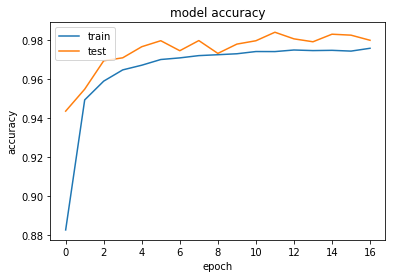

In [7]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("spec_100ms_acc.eps")
plt.savefig("spec_100ms_acc.png",dpi=150)
plt.show()


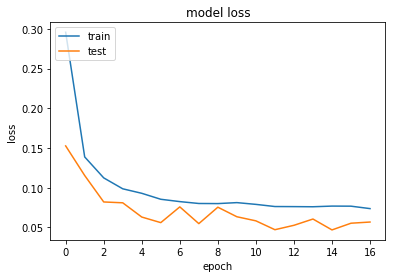

In [8]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("spec_100ms_loss.eps")
plt.savefig("spec_100ms_loss.png",dpi=150)
plt.show()


In [9]:
## to get confusion matrix for training_set
#test_generator.reset()
#test_steps = test_generator.n//test_generator.batch_size 

#y = np.ones((len(os.listdir('./500ms/hold_out/' + classes[0] + '/')),1))
#for i in range(1,num_category ):
    #y = np.vstack((y, np.ones((len(os.listdir('./500ms/hold_out/' + classes[i] + '/')),1))))

#y_pred = model.predict_generator(test_generator,
                                        #steps=test_steps,
                                        #verbose=1)
        #y_pred = np.argmax(y_pred, axis=1).astype('int8')
#print(y_pred)
#print(confusion_matrix(y, y_pred))
#print(classification_report(y, y_pred))
#print(accuracy_score(y, y_pred))
#skplt.metrics.plot_confusion_matrix(y, y_pred)
#plt.show()

## Testing

In [10]:
test_generator.reset()
test_steps = test_generator.n//test_generator.batch_size
y_test = model.predict_generator(test_generator,
                                        steps=test_steps,
                                        verbose=1)

2880/2880 [==============================] - 731s 254ms/step


In [11]:
y_test = np.argmax(y_test, axis=1).astype('int8')

In [12]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
print(true_classes)
print(class_labels)

[0 0 0 ... 3 3 3]
['C', 'FA', 'M', 'S']


In [13]:
from sklearn import metrics
from sklearn.metrics import classification_report
report = metrics.classification_report(true_classes, y_test, target_names=class_labels)
print(report)   

             precision    recall  f1-score   support

          C       0.96      0.99      0.98     14400
         FA       1.00      1.00      1.00     14400
          M       0.97      0.99      0.98     14400
          S       0.99      0.94      0.96     14400

avg / total       0.98      0.98      0.98     57600



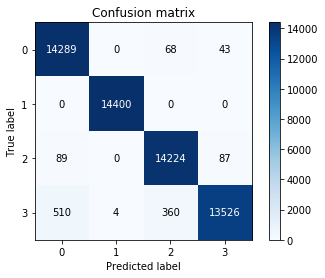

In [14]:
skplt.metrics.plot_confusion_matrix(true_classes, y_test,title='Confusion matrix')
plt.show()

In [15]:
Acc= accuracy_score(true_classes, y_test)
print('Accuracy Score:', Acc)

Accuracy Score: 0.97984375


## Holdout Prediction

In [16]:
hold_generator.reset()
hold_steps = hold_generator.n//hold_generator.batch_size
tic=time.time()
y_holdout = model.predict_generator(hold_generator,
                                        steps=hold_steps,
                                        verbose=1)
tcc=time.time()
print(str(1000*(toc-tic))+"ms")
y_holdout = np.argmax(y_holdout, axis=1).astype('int8')



2880/2880 [==============================] - 1448s 503ms/step
-733805.1640987396ms


[0 0 0 ... 3 3 3]
['C', 'FA', 'M', 'S']
             precision    recall  f1-score   support

          C       0.96      0.99      0.98     14400
         FA       1.00      1.00      1.00     14400
          M       0.97      0.99      0.98     14400
          S       0.99      0.94      0.96     14400

avg / total       0.98      0.98      0.98     57600



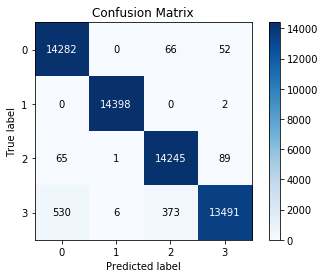

0.97984375


In [17]:
true_classes1 = hold_generator.classes
class_labels1 = list(hold_generator.class_indices.keys())
print(true_classes1)
print(class_labels1)
report1 = metrics.classification_report(true_classes1, y_holdout, target_names=class_labels1)
print(report1)   
skplt.metrics.plot_confusion_matrix(true_classes1, y_holdout )
plt.show()
print(accuracy_score(true_classes, y_test))

### testing using evaluate genrerator

In [18]:
## to get confusion matrix for training_set
test_generator.reset()
test_steps = test_generator.n//test_generator.batch_size 
y = np.ones((len(os.listdir('./100ms/testing_set/' + classes[0] + '/')),1))
for i in range(1,num_category ):
    y = np.vstack((y, np.ones((len(os.listdir('./100ms/testing_set/' + classes[i] + '/')),1))))

test_loss, test_acc = model.evaluate_generator(test_generator,
                                        steps=test_steps,
                                        verbose=1)
print('test acc', test_acc)
print('test loss:', test_loss)

2880/2880 [==============================] - 639s 222ms/step
test acc 0.9798437480711275
test loss: 0.05685298543614373
